In [1]:
import numpy as np
import model

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.utils                          import R_trendfilter
from mrashpen.models                         import mixture_gaussian as mix_gauss

In [2]:
def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

## Generate data with cubic spline (degree 3, order 4)

Signal-to-noise ratio: 0.003


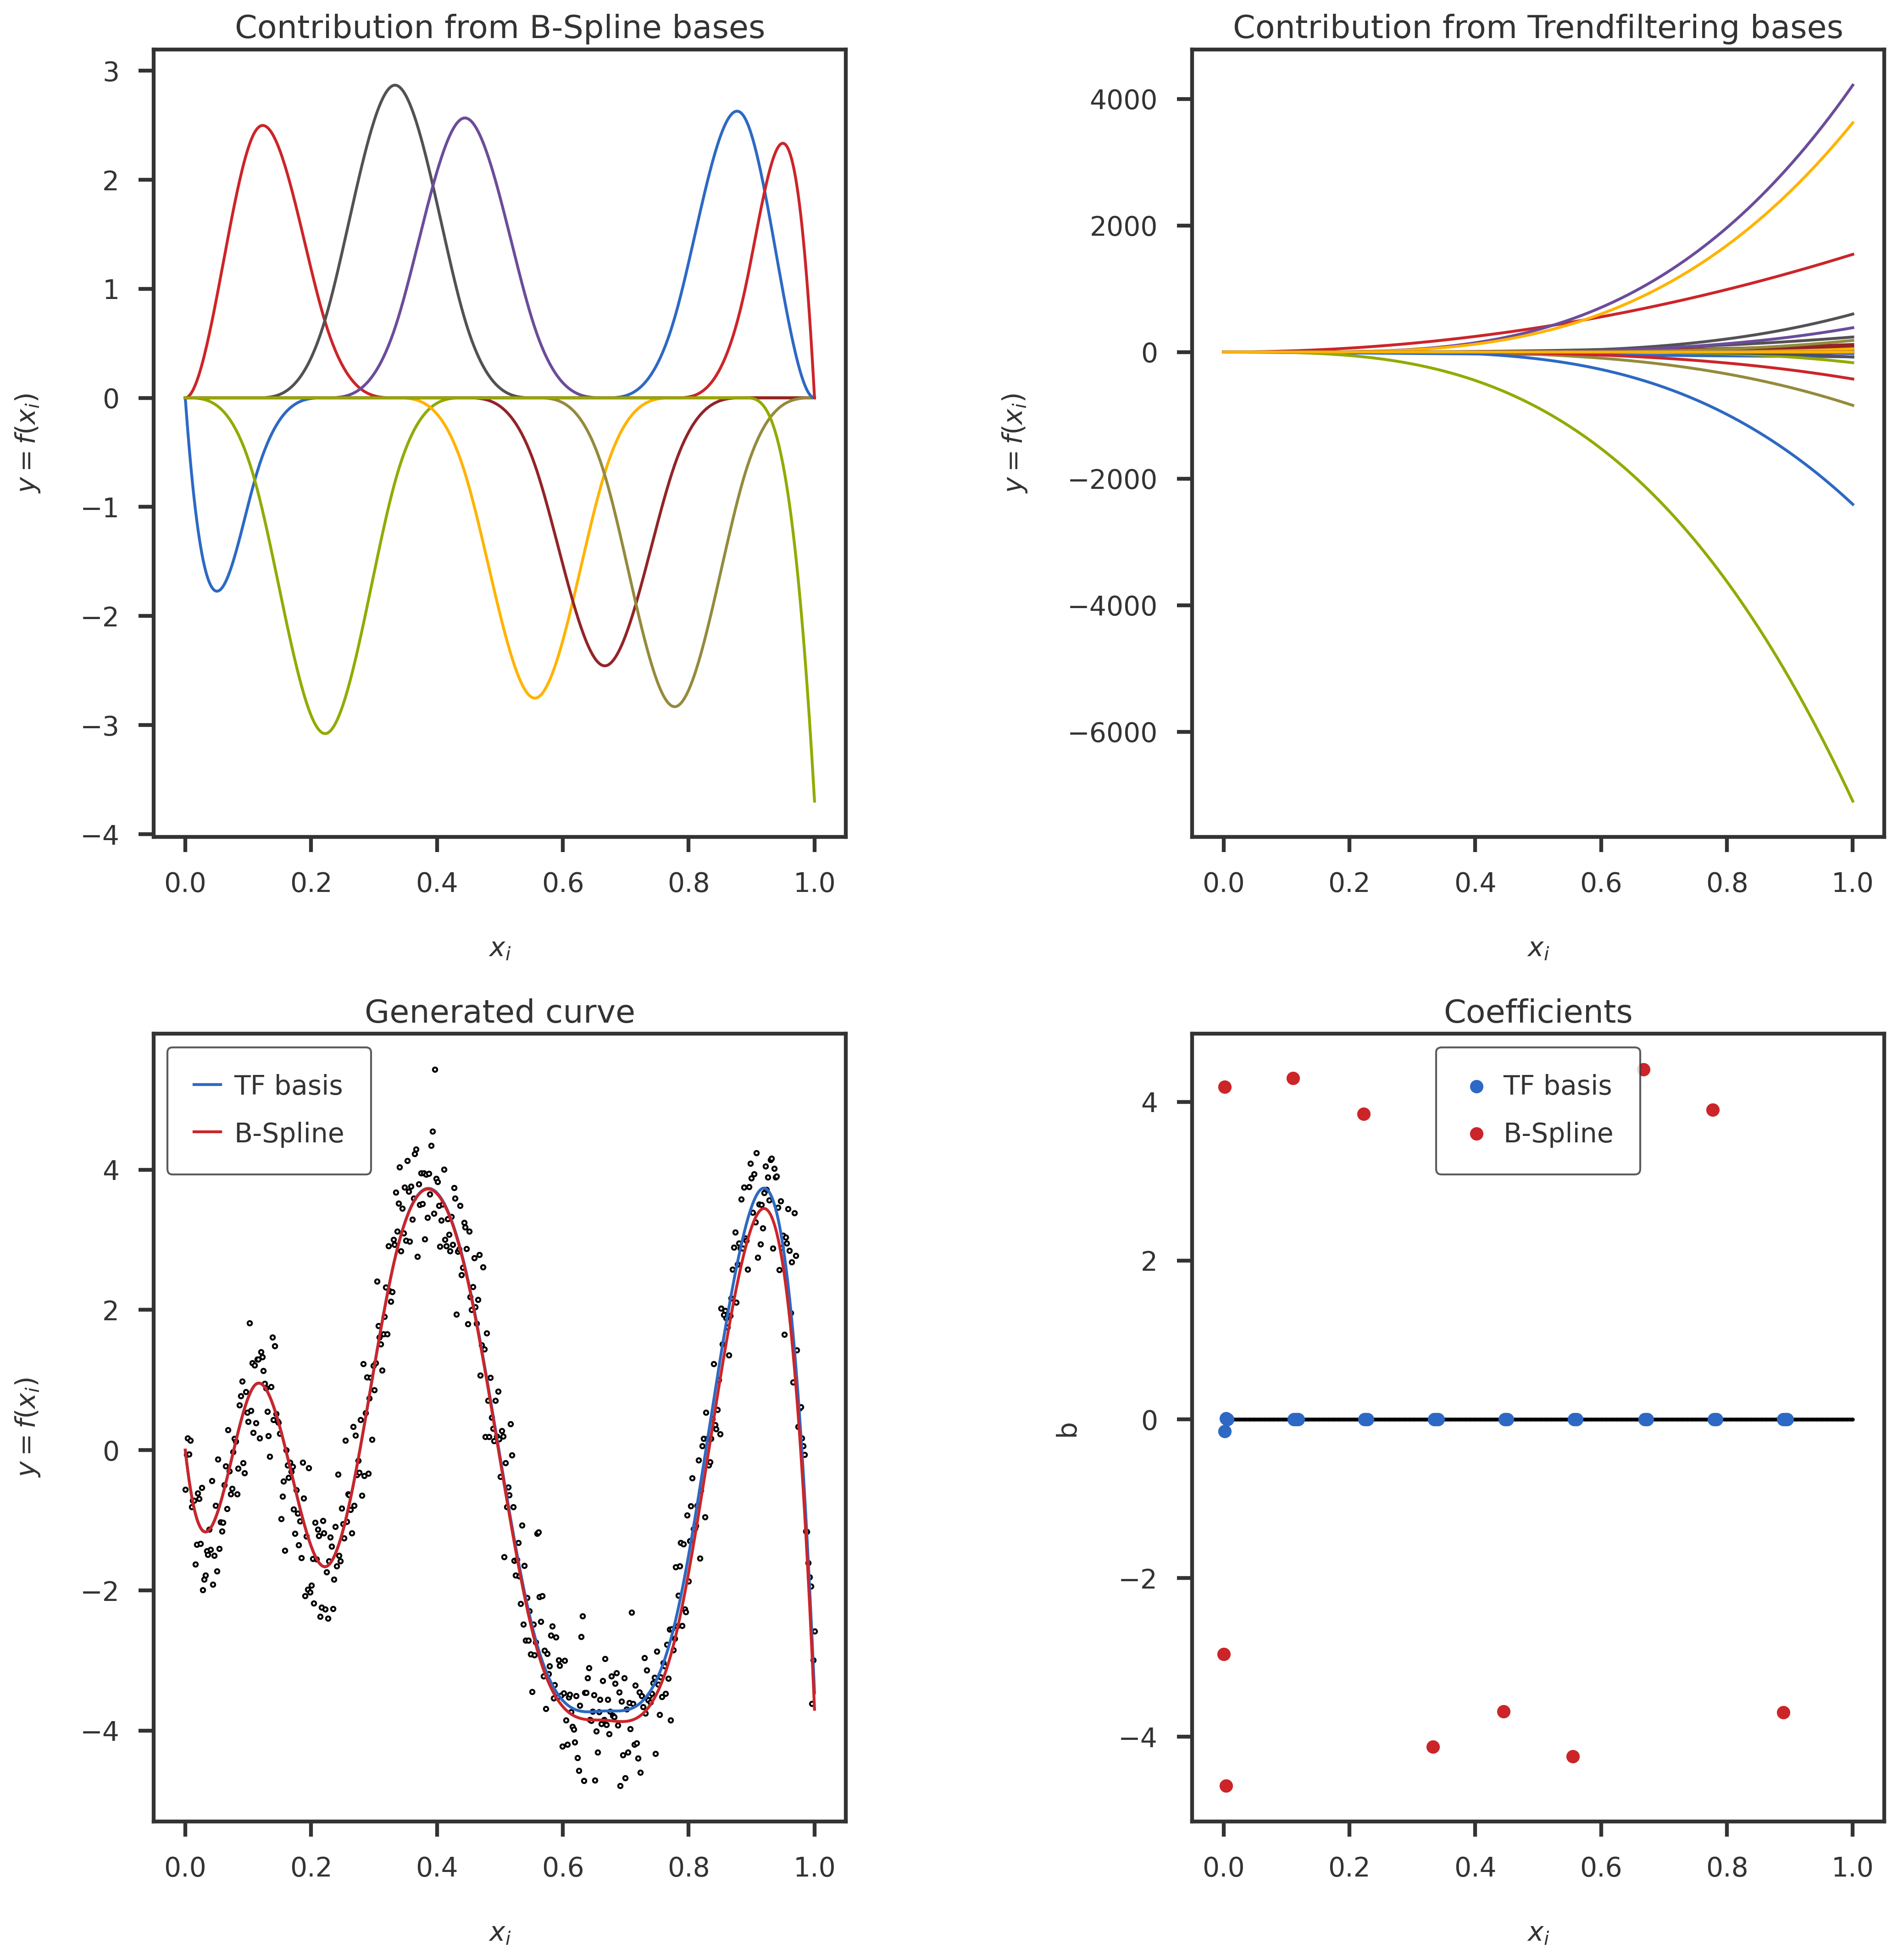

In [32]:
n = 500
nknots = 8
degree = 3
strue = 0.5

x = np.linspace(0, 1, n)
knots = np.linspace(0, 1, nknots + 2)[1:-1]
H, y, ytest, btrue, snr, G, Gb = model.changepoint_from_bspline(x, knots, strue, 
                                            degree = degree, 
                                            signal = "gamma", #bfix = bfix,
                                            seed = 100, include_intercept = False,
                                            get_bsplines = True, eps = 1e-6
                                           )

print(f"Signal-to-noise ratio: {snr:.3f}")

fig = plt.figure(figsize = (14, 14))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, H, btrue, show_base_legend = False)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.25)
for i in range(4):
    axlist[i].set_xlabel(r"$x_i$")
    axlist[i].set_ylabel(r"$y = f(x_i)$")
axlist[3].set_ylabel("b")
plt.show()

In [33]:
tf_y, tf_fit = R_trendfilter.fit(y, order = degree)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [34]:
scale_factor = np.power(n, degree) / np.math.factorial(degree)
tf_basis_inv = model.trendfiltering_basis_matrix_inverse(n, degree) 
tf_bhat  = np.dot(tf_basis_inv, tf_y)

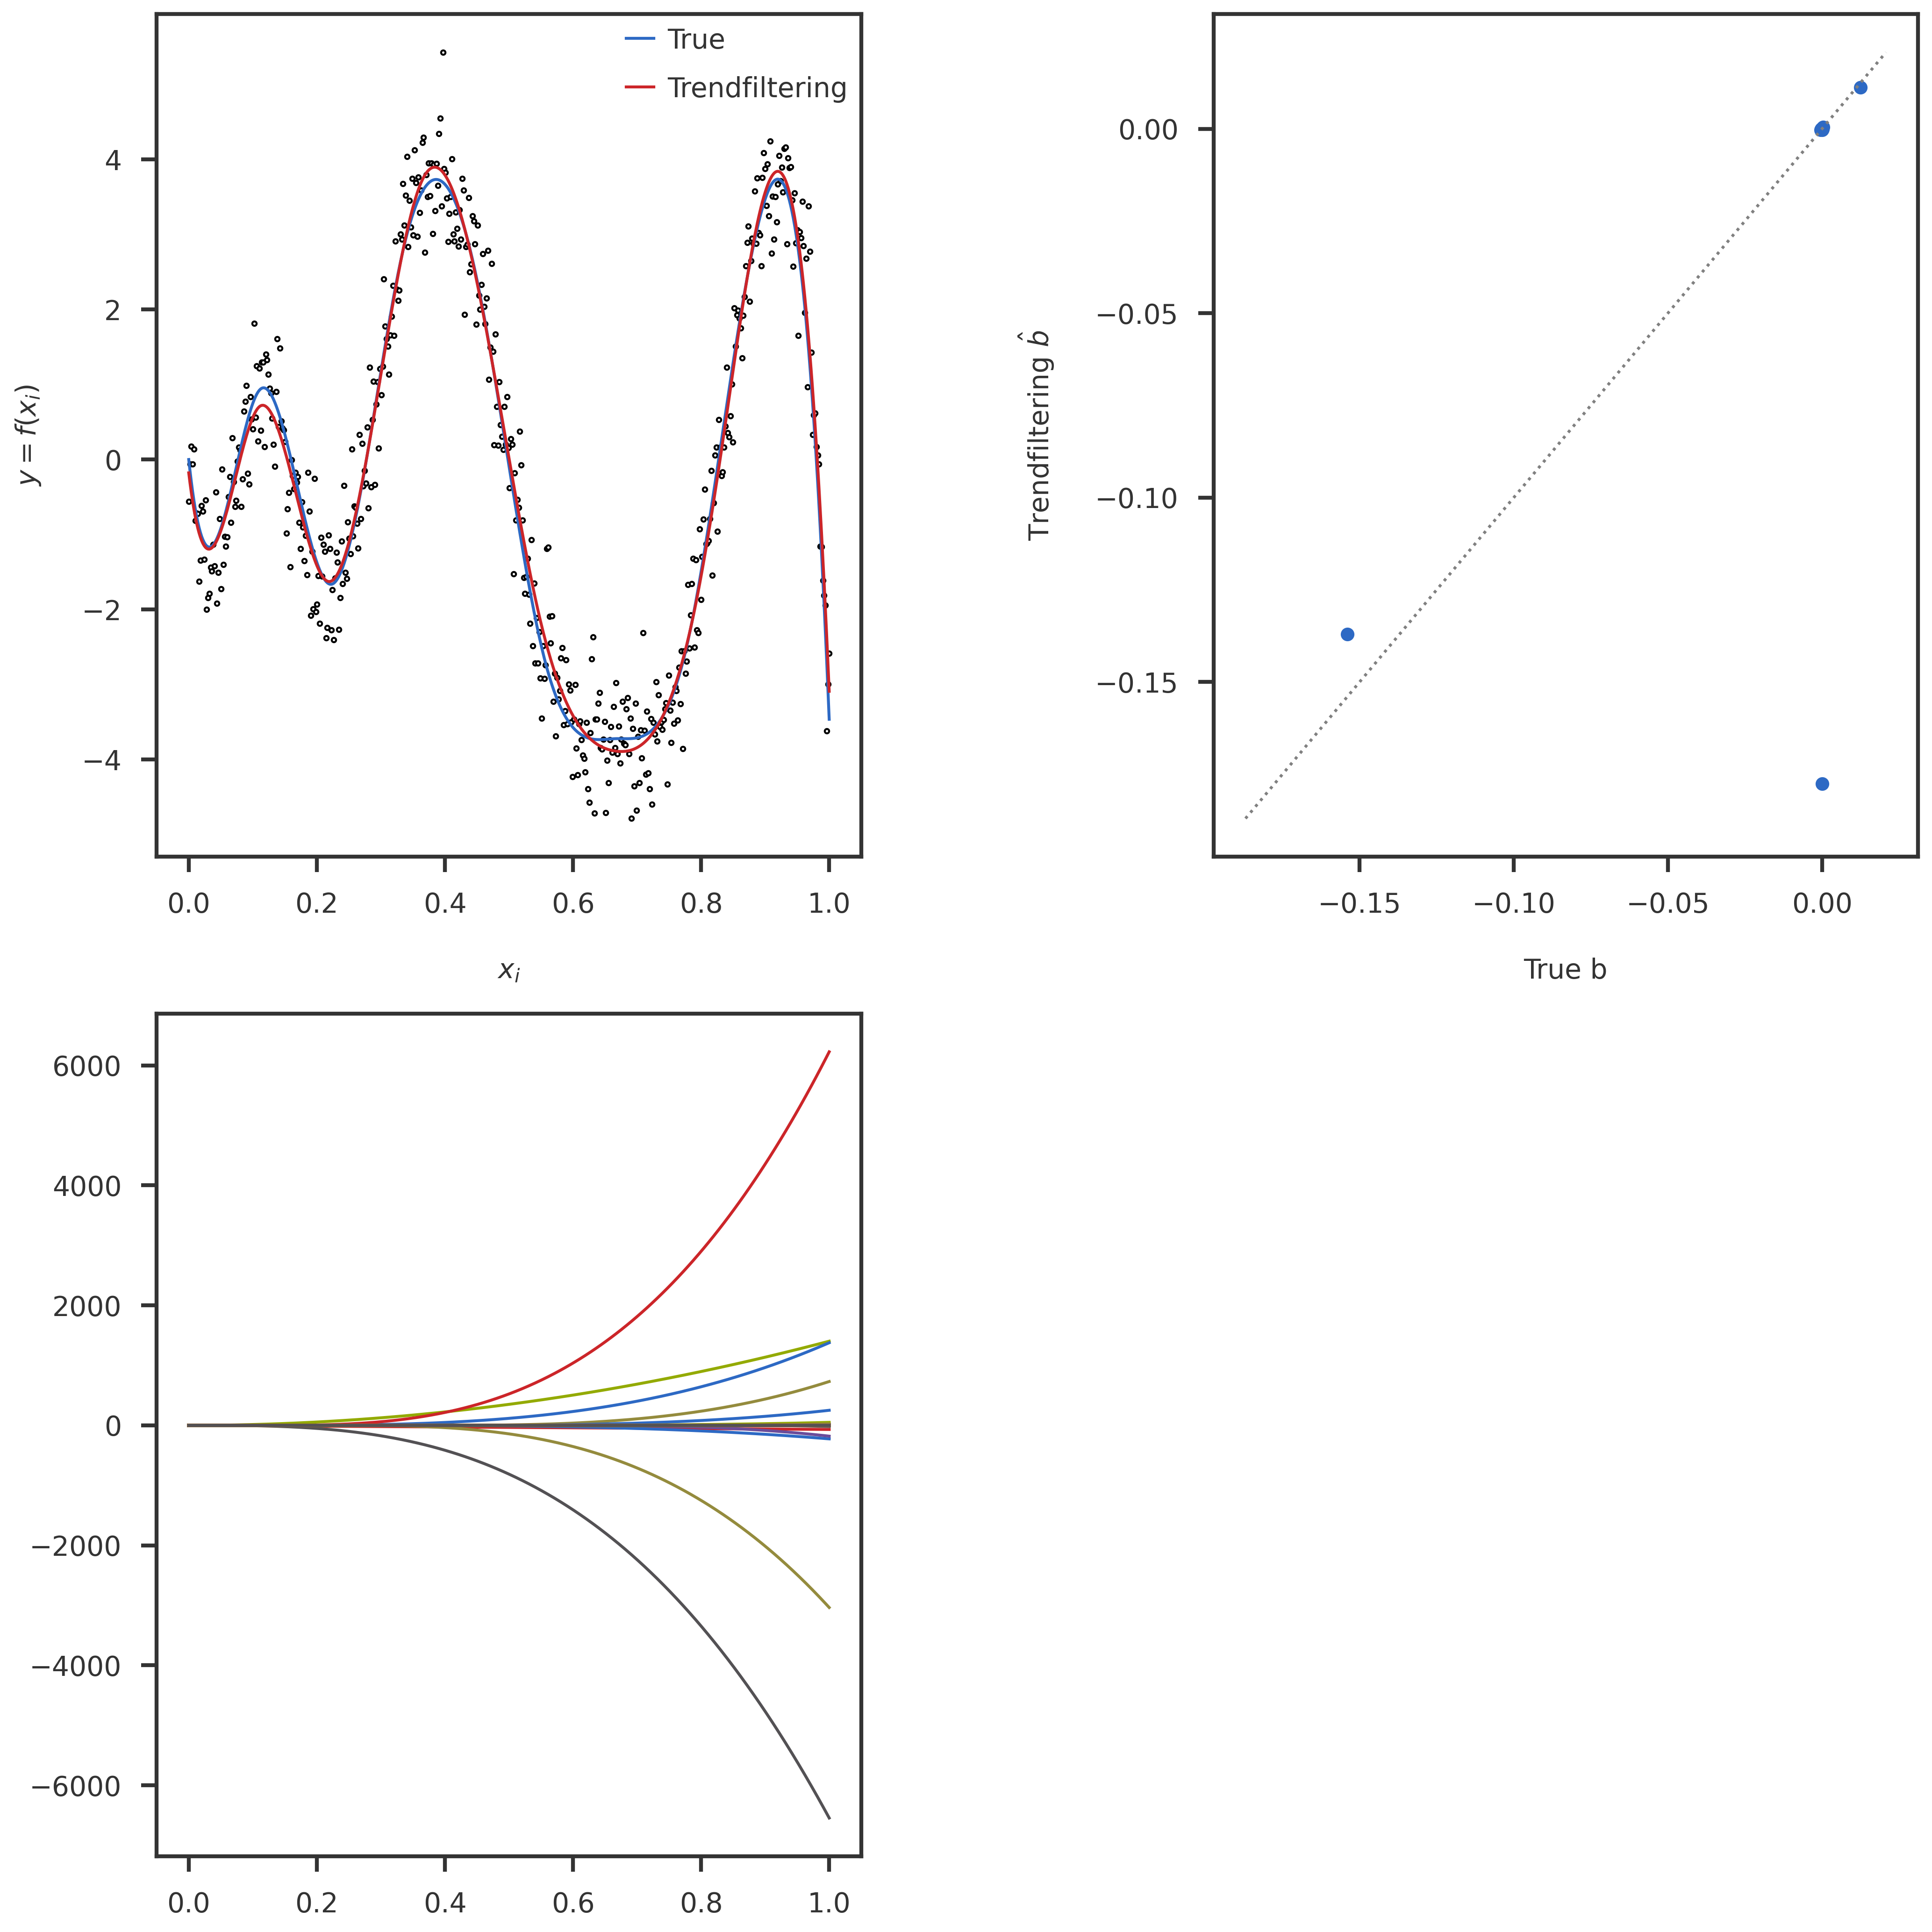

In [35]:
fig = plt.figure(figsize = (14, 14))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax1.scatter(x, y, s = 5, edgecolor = 'black', facecolor='white')
ax1.plot(x, np.dot(H, btrue), label = "True")
ax1.plot(x, tf_y, label = "Trendfiltering")
ax1.legend()
ax1.set_xlabel(r"$x_i$")
ax1.set_ylabel(r"$y = f(x_i)$")

ax2.scatter(btrue, tf_bhat)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("True b")
ax2.set_ylabel(r"Trendfiltering $\hat{b}$")

for i,b in enumerate(tf_bhat):
    if np.abs(b) != 0:
        ax3.plot(x, b * H[:, i])
        
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()

In [36]:
np.var(y - np.dot(H, tf_bhat))

0.27776505229118675

In [37]:
def get_init_w_theta(n, b, wk, sk, s2init):
    plr_init = PLR(method = 'L-BFGS-B', is_prior_scaled = True, optimize_s = False,
                       function_call = 'fortran',
                       debug = False, display_progress = False, calculate_elbo = False, 
                       maxiter = 2000, tol = 1e-8)
    plr_init.fit(np.eye(n), b, sk, binit = b, winit = wk, s2init = s2init)
    return plr_init.theta, plr_init.prior, plr_init


'''
Initialization of theta and w for mr.ash.pen
'''

s2init = np.var(y - np.dot(H, tf_bhat))
k = 10
scale = 2.0
wk, _ = initialize_ash_prior(k, scale = scale)
sk = np.arange(k) * scale
winit = wk.copy()
theta_init, winit, plr_init = get_init_w_theta(n, tf_bhat, wk, sk, s2init)
has_low_sk = winit[-1] > 1e-4
has_high_sk = winit[0] > 0.99
has_unstable_sk = has_low_sk or has_high_sk
print("Low sk", has_low_sk, "High sk", has_high_sk)

while has_unstable_sk:
    print (scale, winit[0], winit[-1])
    if has_low_sk:
        scale = scale * 2
    elif has_high_sk:
        scale = scale / 2
    sk = np.arange(k) * scale
    theta_init, winit, plr_init = get_init_w_theta(n, tf_bhat, wk, sk, s2init)
    has_low_sk = winit[-1] > 1e-4
    has_high_sk = winit[0] > 0.99
    has_unstable_sk = has_low_sk or has_high_sk
# winit = mix_gauss.emfit(genlasso_b, sk)
print(winit)

mr.ash.pen terminated at iteration 25.
Low sk False High sk True
2.0 0.9999999968367157 2.8296360178158536e-10
mr.ash.pen terminated at iteration 23.
1.0 0.9999999947779894 1.8792449272654896e-10
mr.ash.pen terminated at iteration 24.
0.5 0.9999999923998989 3.803718817616224e-11
mr.ash.pen terminated at iteration 23.
0.25 0.9999999705869824 9.208813355836856e-13
mr.ash.pen terminated at iteration 22.
0.125 0.999999942869067 3.626419247785497e-11
mr.ash.pen terminated at iteration 21.
0.0625 0.9999997416771292 1.4813495284857132e-10
mr.ash.pen terminated at iteration 20.
0.03125 0.9999990871962036 7.157560905250102e-10
mr.ash.pen terminated at iteration 19.
0.015625 0.999996629618176 3.160665343809208e-10
mr.ash.pen terminated at iteration 5.
[1.90398589e-20 1.77879758e-20 1.46912249e-20 1.12933356e-20
 9.37445501e-21 1.30569412e-20 1.25886117e-19 1.16053740e-15
 1.00000000e+00 4.43889793e-13]


In [38]:
def softmax(x, base = np.exp(1)):
    if base is not None:
        beta = np.log(base)
        x = x * beta
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis = 0, keepdims = True)

def penalty_operator(z, wk, std, sk, dj):
    nm = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    tvar = (std * std) / dj
    lambdaj = - nm.logML - 0.5 * tvar * np.square(nm.logML_deriv)
    return lambdaj

def shrinkage_operator(nm):
    M        = nm.y + nm.yvar * nm.logML_deriv
    M_bgrad  = 1       + nm.yvar * nm.logML_deriv2
    M_wgrad  = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
    M_s2grad = (nm.logML_deriv / nm._d) + (nm.yvar * nm.logML_deriv_s2deriv)
    return M, M_bgrad, M_wgrad, M_s2grad

def unshrink_b(b, std, wk, sk, dj, theta = None, max_iter = 100, tol = 1e-8):
    # this is the initial value of theta
    if theta is None:
        theta = np.zeros_like(b)
    # Newton-Raphson iteration
    for itr in range(max_iter):
        nmash = NormalMeansASHScaled(theta, std, wk, sk, d = dj)
        Mtheta, Mtheta_bgrad, _, _ = shrinkage_operator(nmash)
        theta_new = theta - (Mtheta - b) / Mtheta_bgrad
        diff = np.sum(np.square(theta_new - theta))
        theta = theta_new
        obj = np.sum(- nmash.logML - 0.5 * nmash.yvar * np.square(nmash.logML_deriv))
        print(obj)
        if diff <= tol:
            break
    return theta

def shrink_theta(z, std, wk, sk, dj):
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    Mb = shrinkage_operator(nmash)[0]
    return Mb

def penalty_operator_lagrangian(z, wk, std, sk, dj, lgrng, b):
    Mt  = shrink_theta(z, std, wk, sk, dj)
    hwt = penalty_operator(z, wk, std, sk, dj)
    obj = np.sum(hwt) + np.sum(lgrng * (Mt - b))
    return obj

def penalty_operator_lagrangian_deriv(z, wk, std, sk, dj, lgrng, b):
    '''
    The Normal Means model
    '''
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    '''
    gradient w.r.t lambda_j (lagrangian penalty)
    '''
    M, M_bgrad, M_wgrad, M_s2grad  = shrinkage_operator(nmash)
    dLdl = M - b
    '''
    gradient w.r.t wk (prior mixture coefficients)
    '''
    tvar  = (strue * strue) / dj
    v2_ld_ldwd = tvar.reshape(-1, 1) * nmash.logML_deriv.reshape(-1, 1) * nmash.logML_deriv_wderiv
    ## gradient of first term and second term of the lagrangian
    l1_wgrad = - nmash.logML_wderiv - v2_ld_ldwd
    l2_wgrad = lgrng.reshape(-1, 1) * M_wgrad
    dLdw = np.sum(l1_wgrad + l2_wgrad, axis = 0)
    '''
    gradient w.r.t theta
    '''
    l1_tgrad = - nmash.logML_deriv  - tvar * nmash.logML_deriv * nmash.logML_deriv2
    l2_tgrad = lgrng * (1 + tvar * nmash.logML_deriv2)
    dLdt = l1_tgrad + l2_tgrad
    return dLdl, dLdw, dLdt

def objective_numeric_lagrangian(params, std, sk, dj, b, p, k, softmax_base):
    zj = params[:p]
    lj = params[p:2*p]
    ak = params[2*p:]
    wk = softmax(ak, base = softmax_base)
    dLdl, dLdw, dLdt = penalty_operator_lagrangian_deriv(zj, wk, strue, sk, dj, lj, btrue)
    akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
    dLda = np.sum(dLdw * akjac, axis = 1)
    obj = np.sqrt(np.sum(np.square(dLdl)) + np.sum(np.square(dLda)) + np.sum(np.square(dLdt)))
    return obj

### Check the initialization

113.8703364262781
139.70957329975442


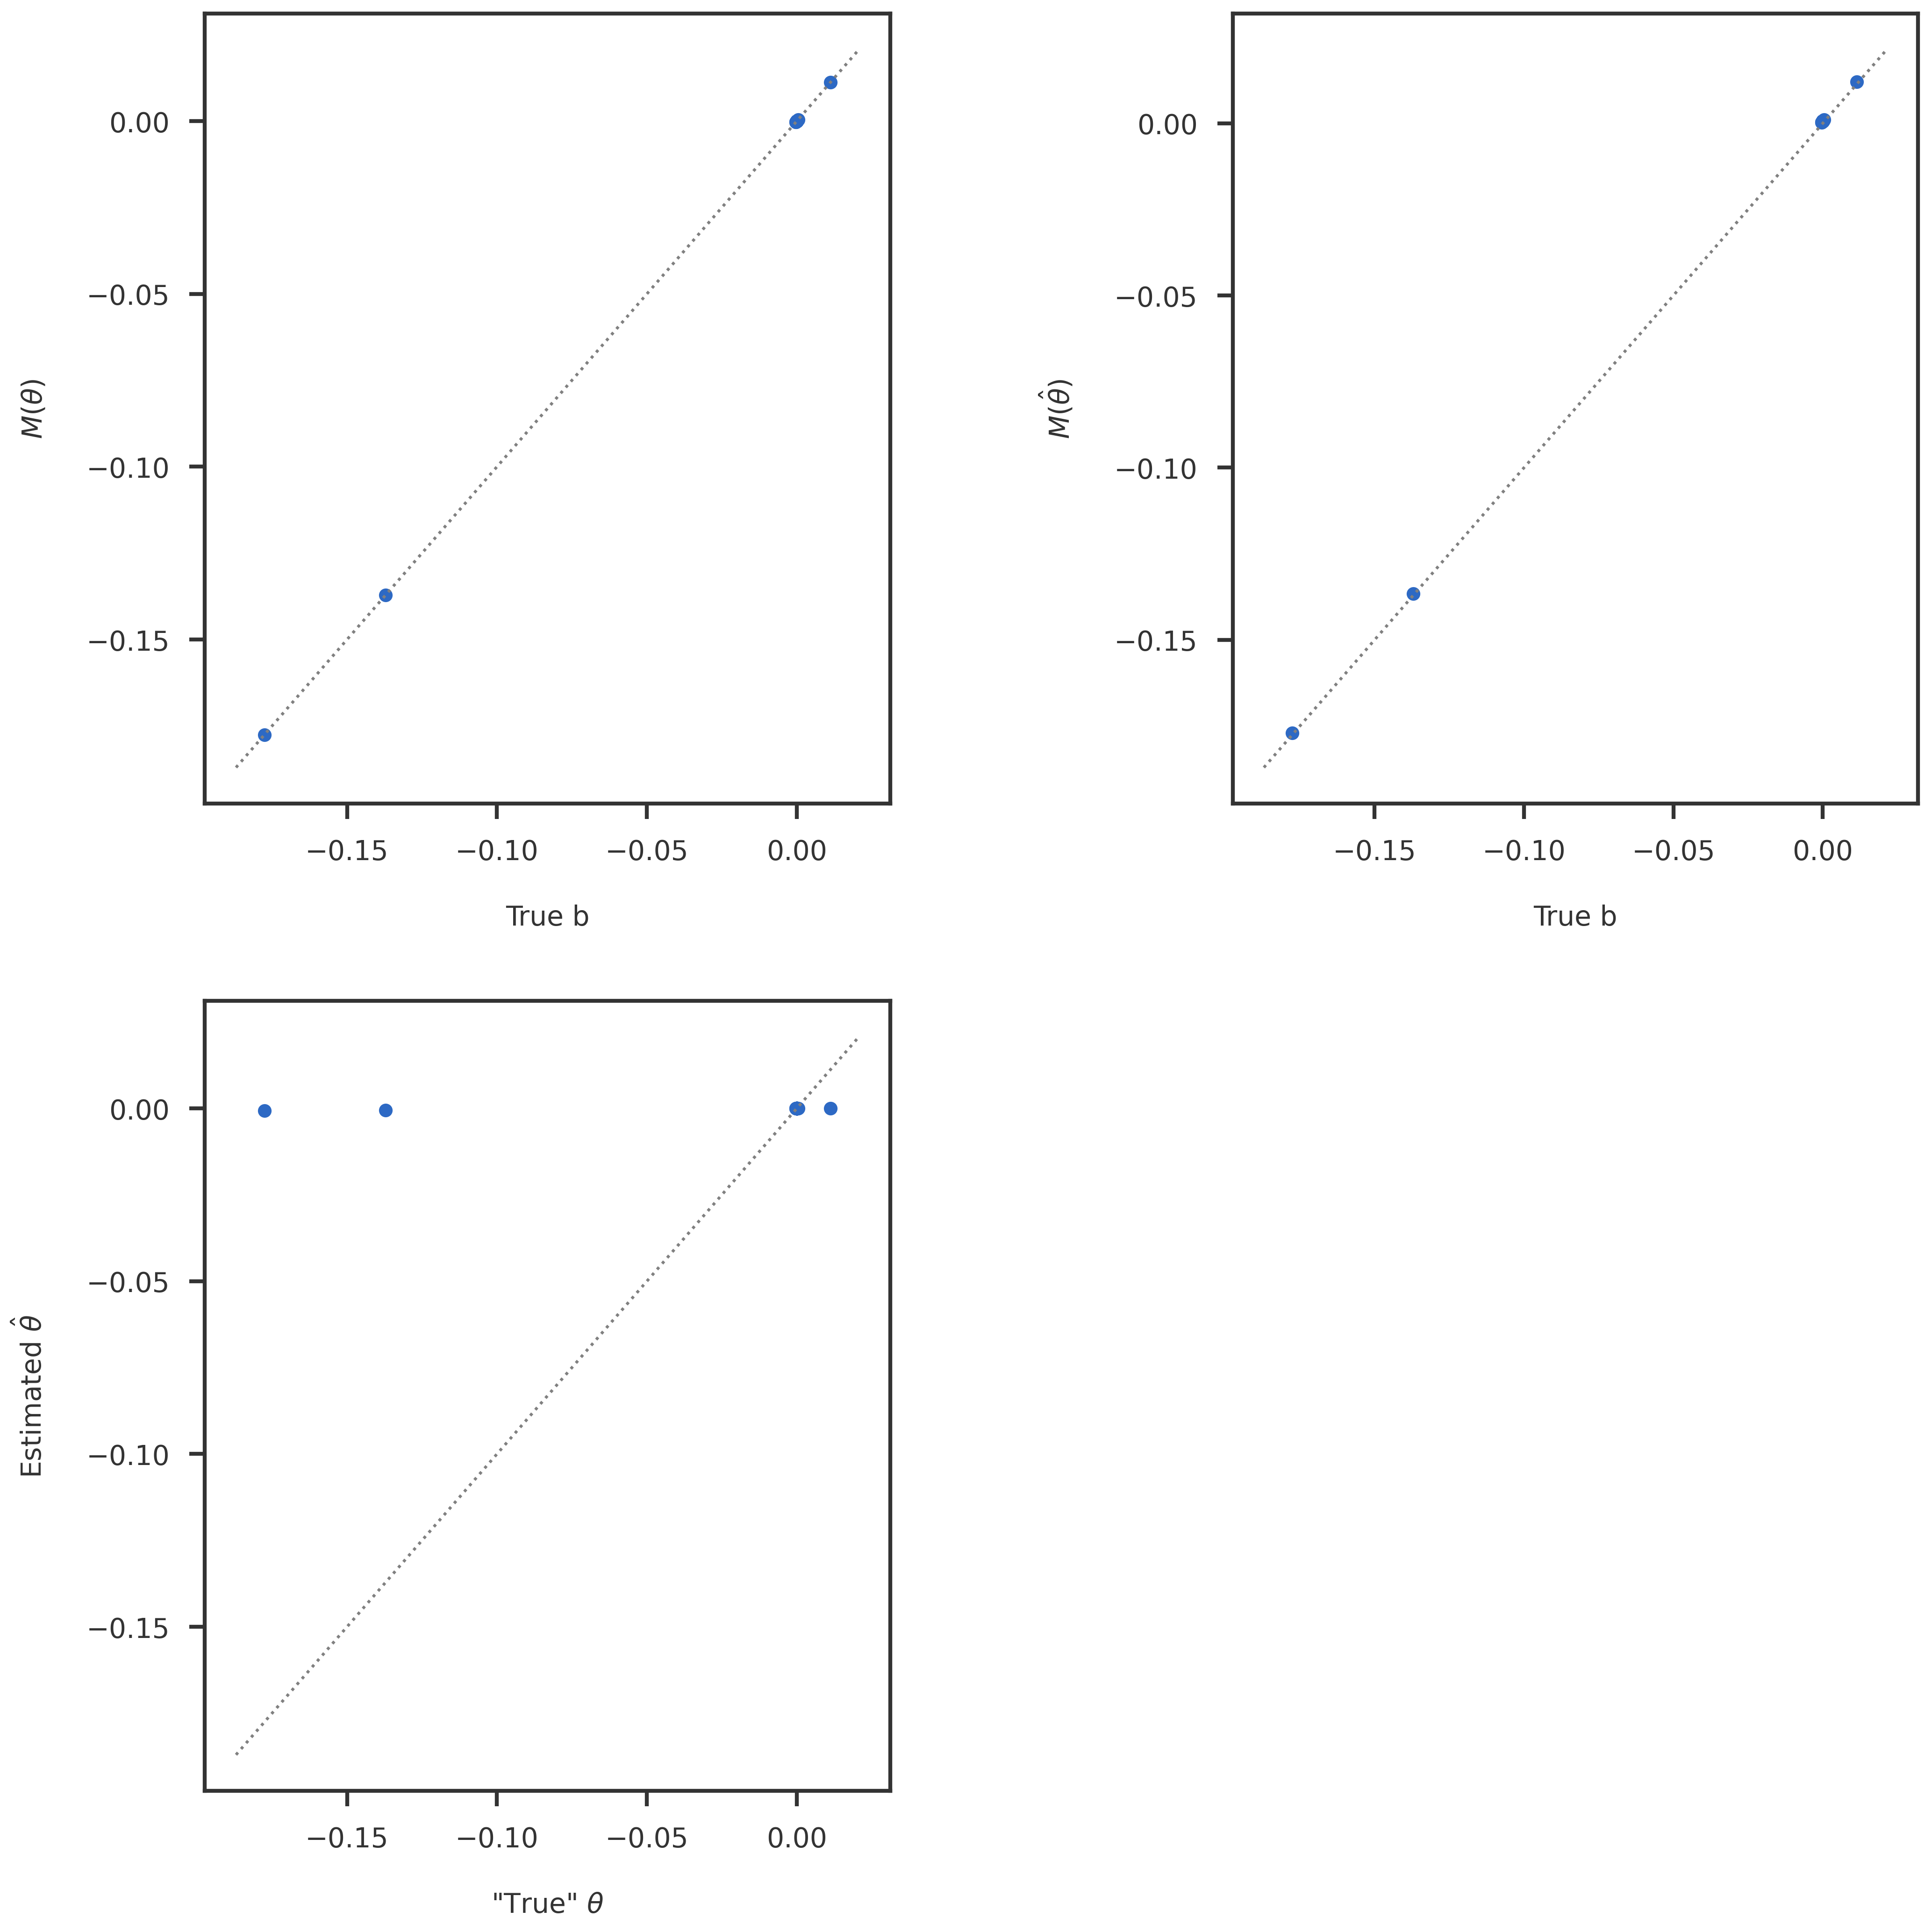

In [42]:
dj = np.ones(n)
z_newraph = unshrink_b(tf_bhat, strue, winit, sk, dj)
b_newraph = shrink_theta(z_newraph, strue, winit, sk, dj)

fig = plt.figure(figsize = (14, 14))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

ax1.scatter(tf_bhat, b_newraph)
ax1.set_xlabel("True b")
ax1.set_ylabel(r"$M(\theta)$")
mpl_utils.plot_diag(ax1)

ax2.scatter(tf_bhat, plr_init.theta)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("True b")
ax2.set_ylabel(r"$M(\hat{\theta})$")

ax3.scatter(b_newraph, plr_init.coef)
mpl_utils.plot_diag(ax3)
ax3.set_xlabel("\"True\" " + r"$\theta$")
ax3.set_ylabel(r"Estimated $\hat{\theta}$")

plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.25)
plt.show()

In [26]:
1 / (plr_init.theta[4] / z_newraph[4])

6.235975466520126e-09

In [20]:
n * np.sqrt(s2init)

263.93553473351517

In [29]:
np.sum(np.square(H.T), axis = 0)

array([1.00000000e+00, 2.00000000e+00, 6.00000000e+00, 2.00000000e+01,
       6.30000000e+01, 1.72000000e+02, 4.08000000e+02, 8.62000000e+02,
       1.66100000e+03, 2.97400000e+03, 5.01800000e+03, 8.06400000e+03,
       1.24430000e+04, 1.85520000e+04, 2.68600000e+04, 3.79140000e+04,
       5.23450000e+04, 7.08740000e+04, 9.43180000e+04, 1.23596000e+05,
       1.59735000e+05, 2.03876000e+05, 2.57280000e+05, 3.21334000e+05,
       3.97557000e+05, 4.87606000e+05, 5.93282000e+05, 7.16536000e+05,
       8.59475000e+05, 1.02436800e+06, 1.21365200e+06, 1.42993800e+06,
       1.67601700e+06, 1.95486600e+06, 2.26965400e+06, 2.62374800e+06,
       3.02071900e+06, 3.46434800e+06, 3.95863200e+06, 4.50779000e+06,
       5.11626900e+06, 5.78875000e+06, 6.53015400e+06, 7.34564800e+06,
       8.24065100e+06, 9.22084000e+06, 1.02921560e+07, 1.14608100e+07,
       1.27332890e+07, 1.41163620e+07, 1.56170860e+07, 1.72428120e+07,
       1.90011910e+07, 2.09001800e+07, 2.29480480e+07, 2.51533820e+07,
      

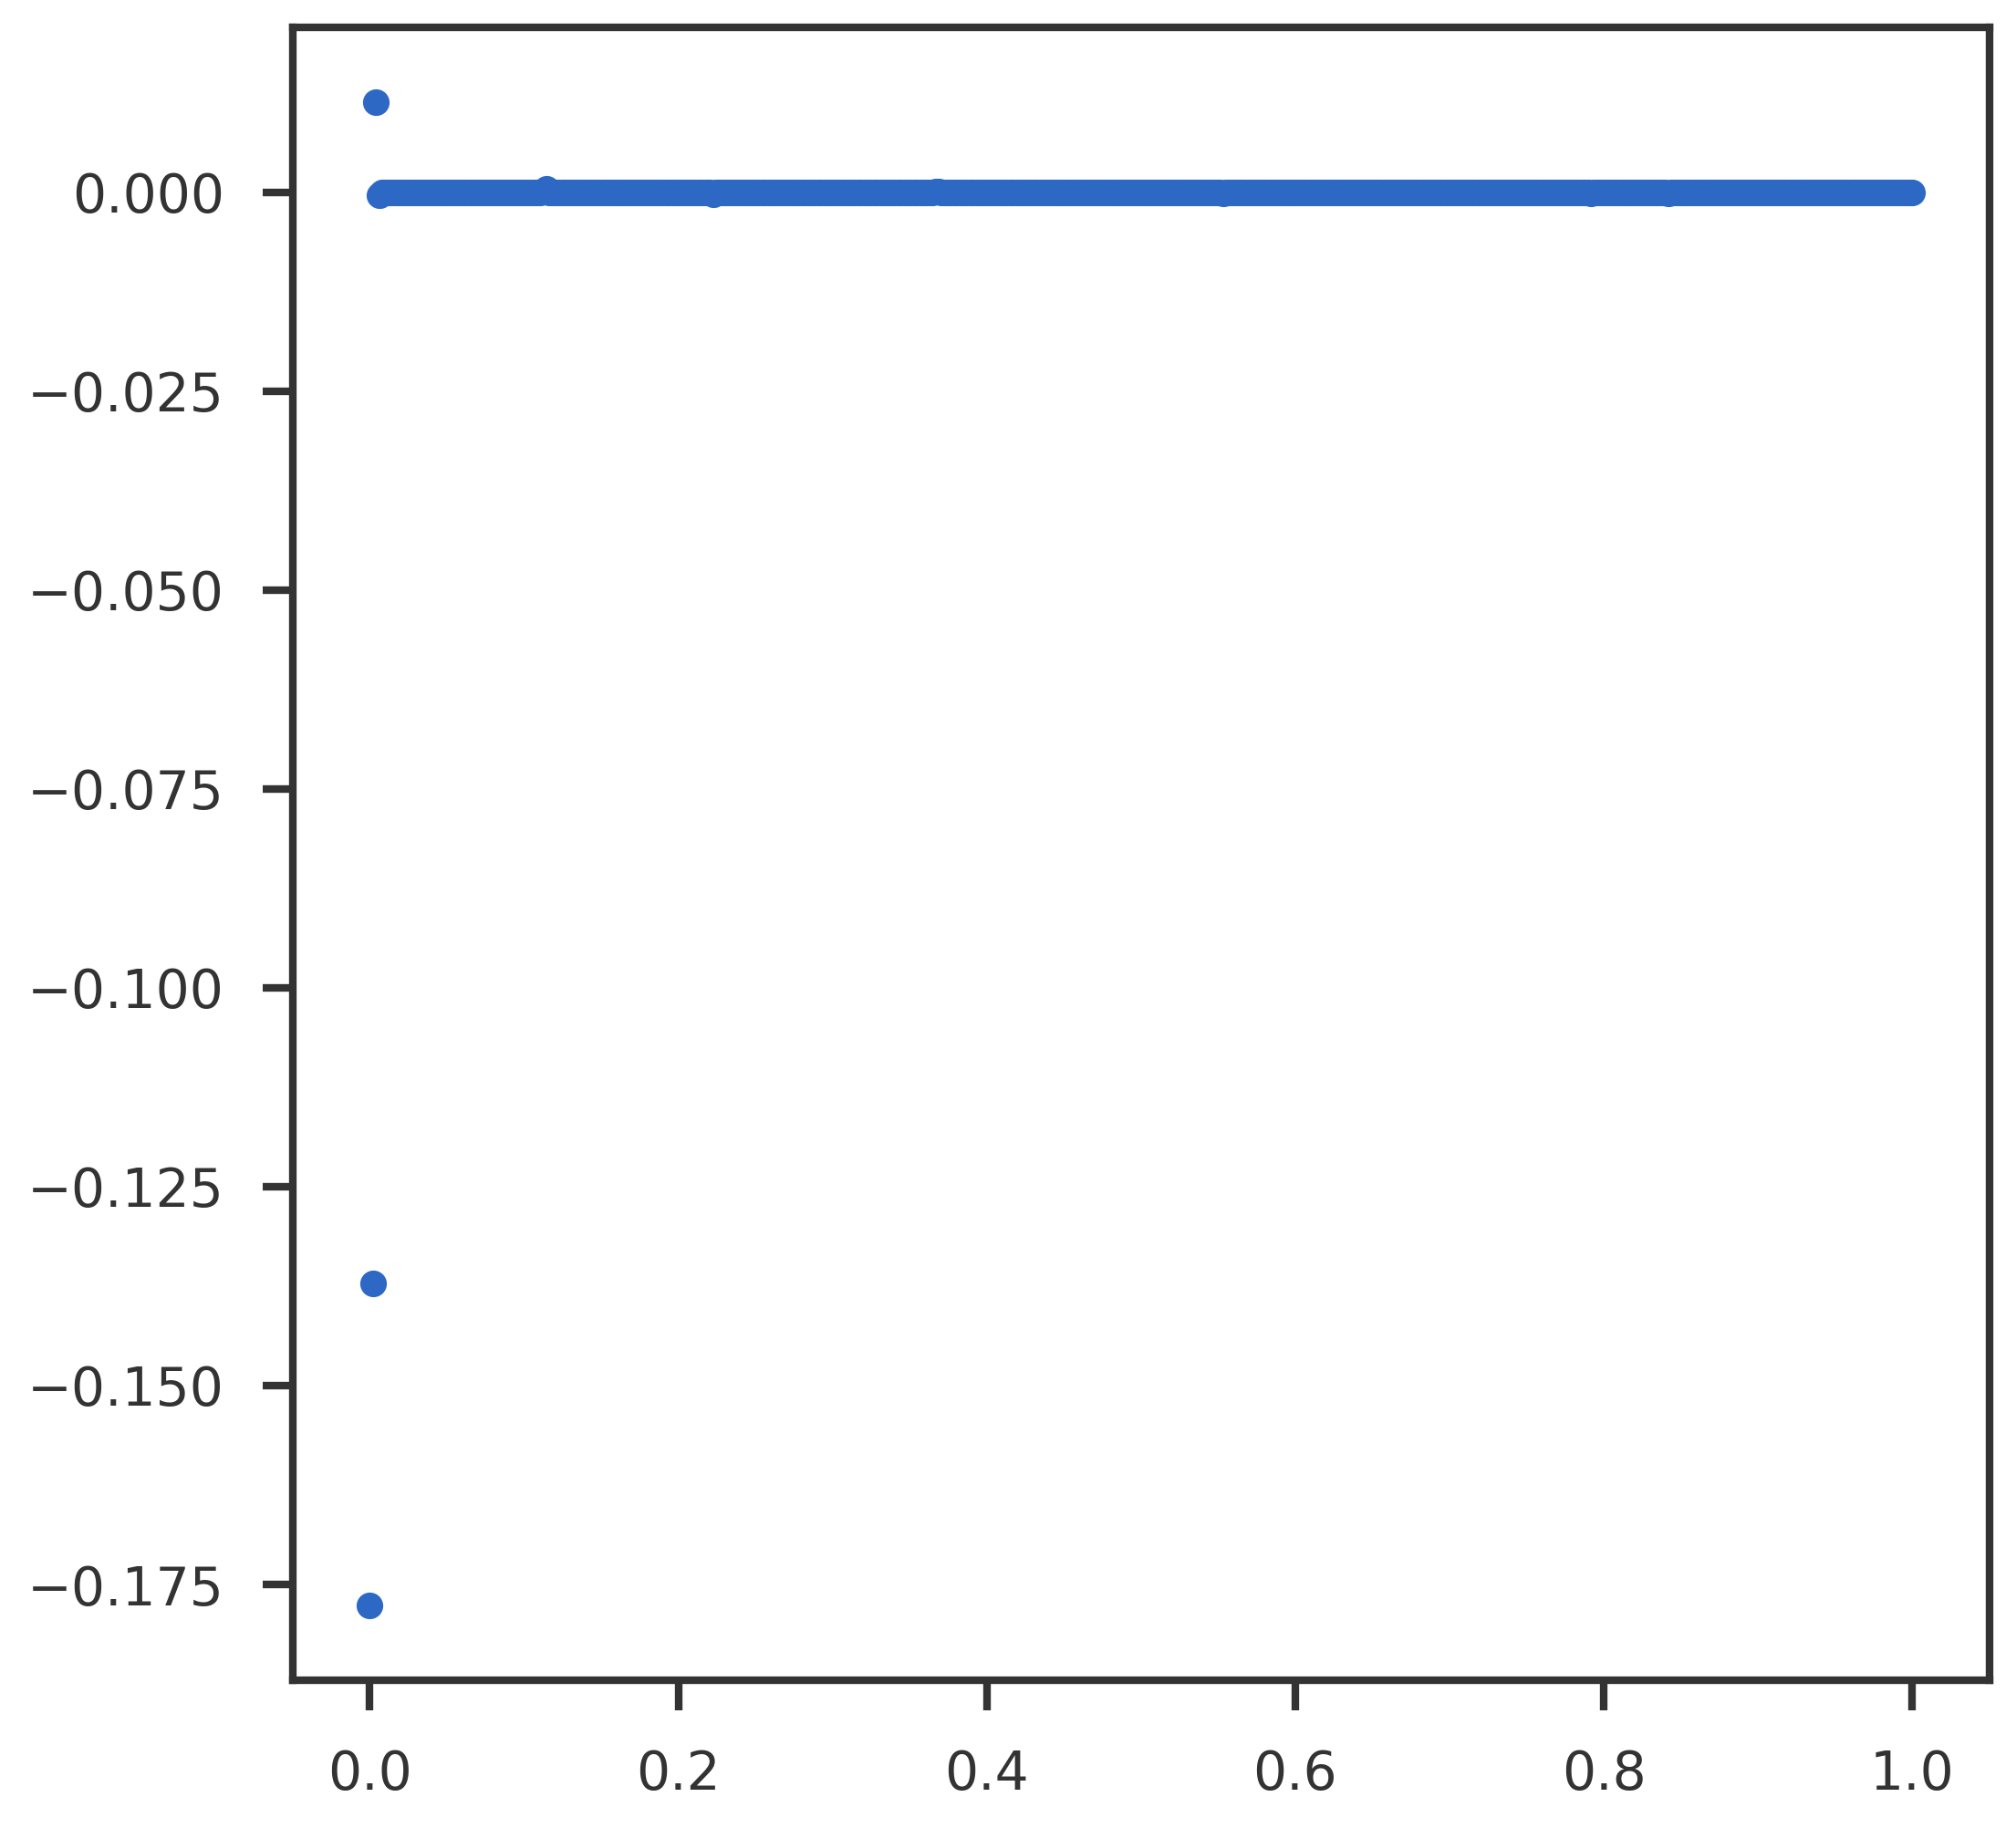

In [39]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x, tf_bhat )
#mpl_utils.plot_diag(ax1)
plt.show()

In [11]:
plr_init.coef

array([-6.88835764e-04, -5.31239613e-04,  4.65631991e-05,  1.11562214e-06,
        2.36251754e-06,  2.36251754e-06,  2.36251754e-06,  2.36251754e-06,
        2.36251754e-06,  2.36251754e-06,  2.36251753e-06,  2.36251755e-06,
        2.36251753e-06,  2.36251756e-06,  2.36251752e-06,  2.36251755e-06,
        2.36251753e-06,  2.36251754e-06,  2.36251755e-06,  2.36251753e-06,
        2.36251754e-06,  2.36251756e-06,  2.36251751e-06,  2.36251757e-06,
        2.36251756e-06,  2.36251743e-06,  2.36251766e-06,  2.36251751e-06,
        2.36251754e-06,  2.36251739e-06,  2.36251782e-06,  2.36251747e-06,
        2.36251718e-06,  2.36251812e-06,  2.36251715e-06,  2.36251746e-06,
        2.36251805e-06,  2.36251686e-06,  2.36251809e-06,  2.36251729e-06,
        2.36251756e-06,  2.36251753e-06,  2.36251795e-06,  2.36251641e-06,
        2.36251904e-06,  2.36251635e-06,  2.36251816e-06,  2.36251720e-06,
        2.36251811e-06,  2.36251659e-06,  2.36251844e-06,  2.36251732e-06,
        2.36251687e-06,  

In [176]:
plr_init.coef

array([-3.69986938e+06, -2.85651186e+06,  2.35191732e+05, -6.62390974e+03,
       -1.02695630e-06,  2.68766491e-06, -3.35842465e-06,  2.83569464e-06,
       -4.20034378e-06,  1.18608826e-05, -2.92081174e-05,  5.16623781e-05,
       -7.93346870e-05,  1.00808251e-04, -9.05479395e-05,  7.47920244e-05,
       -7.47365133e-05,  2.30833871e-05,  6.65763740e-05, -6.10992738e-05,
       -2.40085729e-05,  9.43412015e-05, -1.59428026e-04,  1.74545563e-04,
        8.83182416e-05, -5.63493696e-04,  6.19458188e-04, -1.44745327e-04,
        1.12872674e-05, -7.99207922e-04,  1.46771484e-03, -3.63190959e-04,
       -1.90821433e-03,  3.07917580e-03, -2.05233515e-03, -4.29864477e-04,
        2.70325891e-03, -3.62144805e-03,  2.92937202e-03, -1.33396188e-03,
        9.63072215e-05, -6.23702479e-05,  2.18280718e-03, -5.98570036e-03,
        7.97373741e-03, -6.31242512e-03,  3.28875815e-03, -1.80732512e-03,
        3.01231725e-03, -5.03130408e-03,  4.79176883e-03, -1.18906736e-03,
       -3.54454891e-03,  

In [162]:
plr_init = PLR(method = 'L-BFGS-B', is_prior_scaled = True, optimize_s = False,
                       function_call = 'fortran',
                       debug = False, display_progress = False, calculate_elbo = False, 
                       maxiter = 2000, tol = 1e-8)
plr_init.fit(np.eye(n), tf_bhat * scale_factor, sk, binit = tf_bhat * scale_factor, winit = wk, s2init = s2init)

mr.ash.pen terminated at iteration 0.


In [167]:
tf_bhat[3] * scale_factor

-6623.909740294253

In [188]:
'''
Use the initial theta for mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True, function_call = 'fortran',
                debug = False, display_progress = False, calculate_elbo = True,
                maxiter = 4000, tol = 1e-8)
plr_lbfgs.fit(H / scale_factor, y, sk, binit = theta_init, winit = winit, s2init = s2init, is_binit_coef = False)

'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(H, y, sk, binit = tf_bhat, winit = winit, s2init = s2init)

mr.ash.pen terminated at iteration 913.
Mr.ASH terminated at iteration 9.


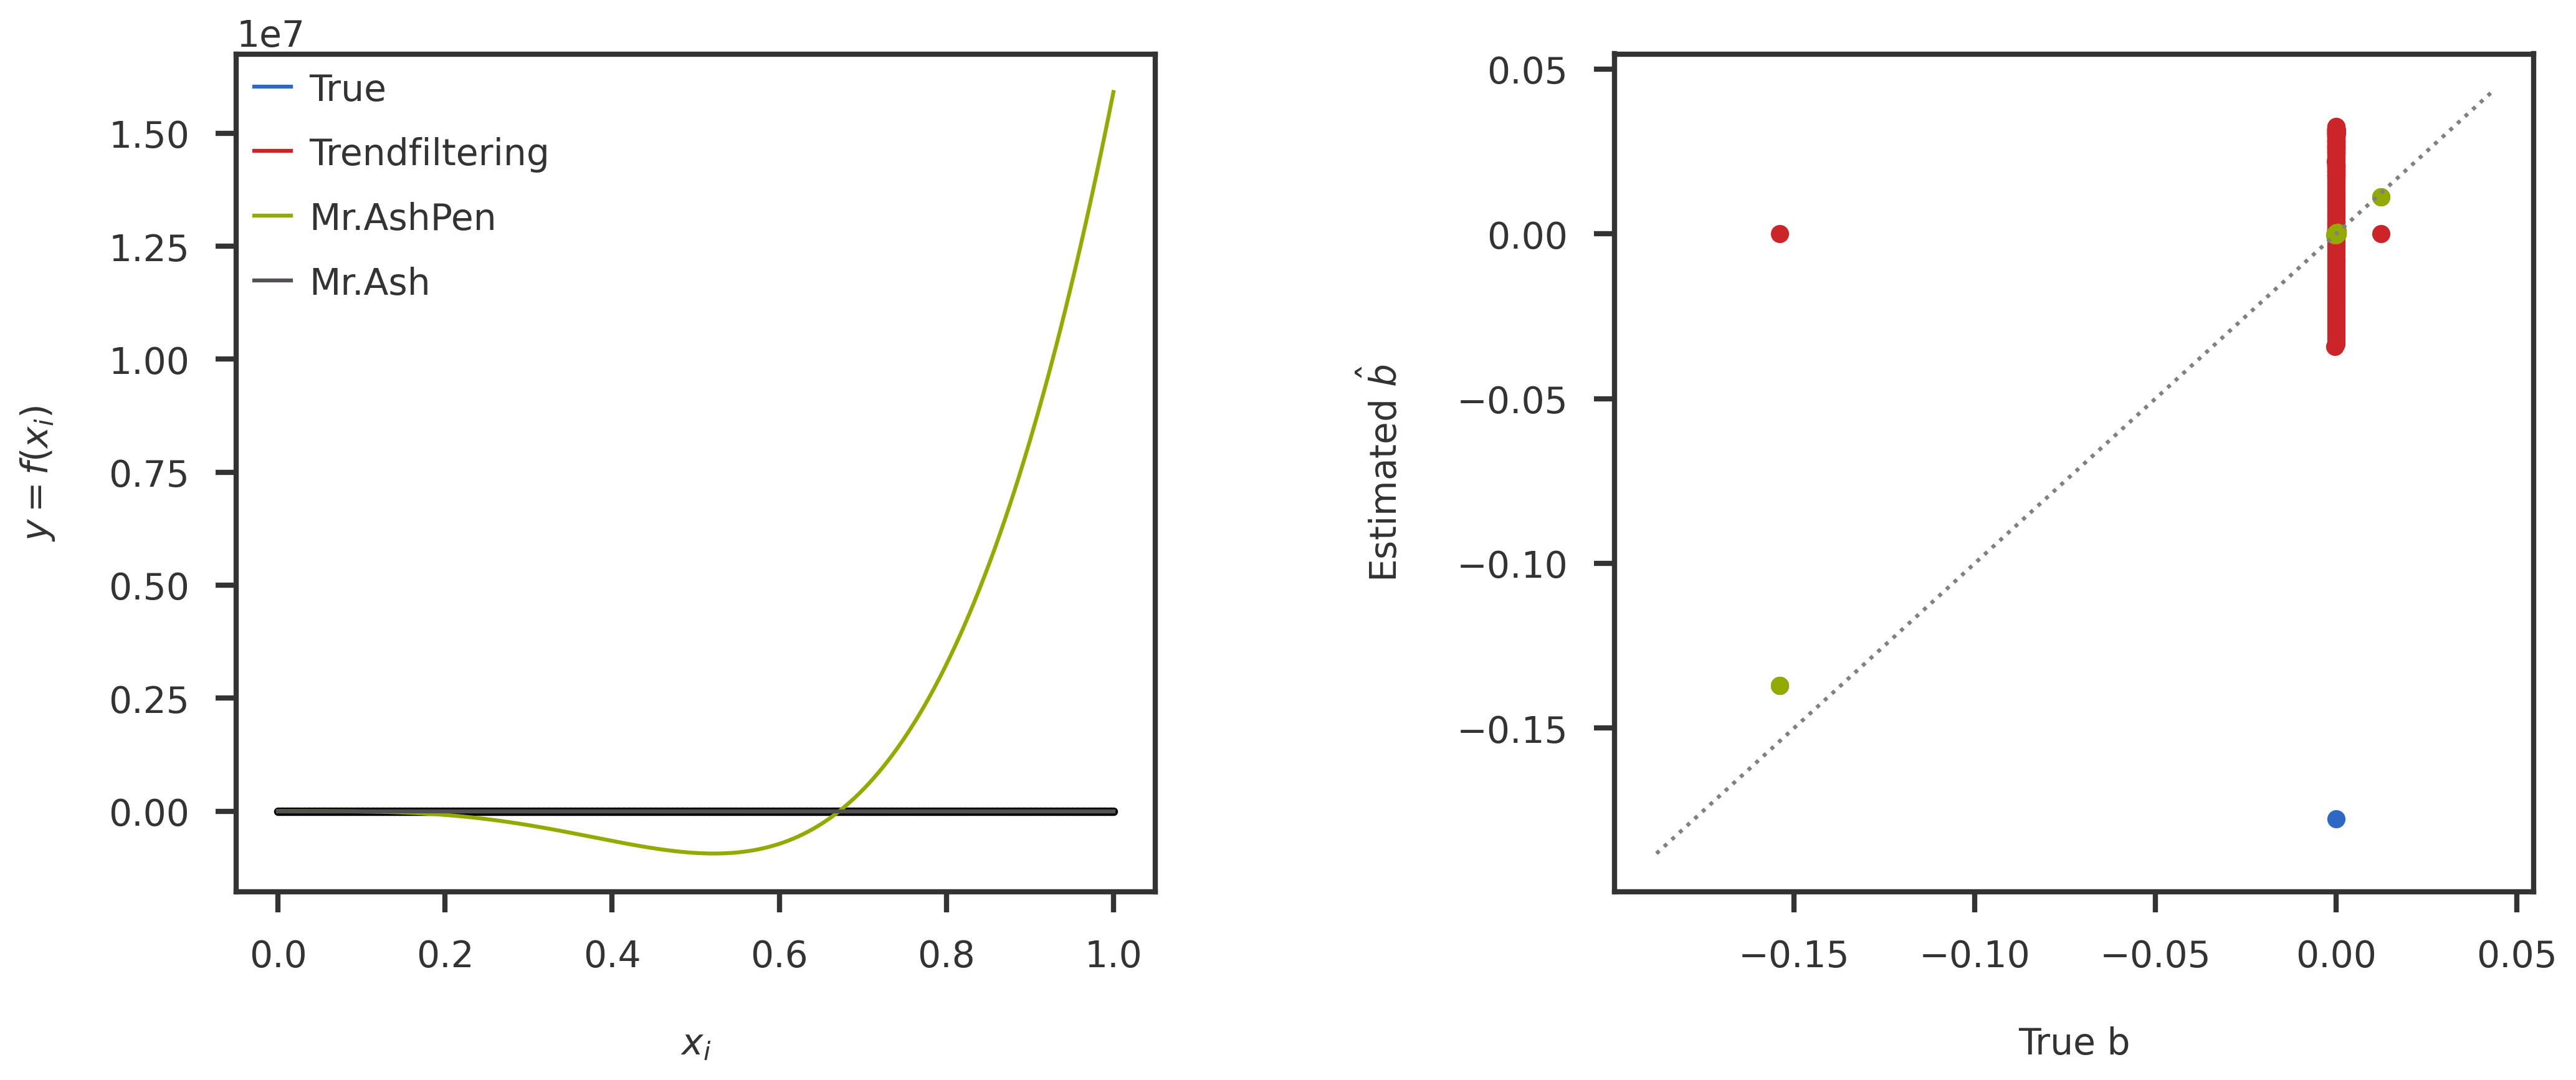

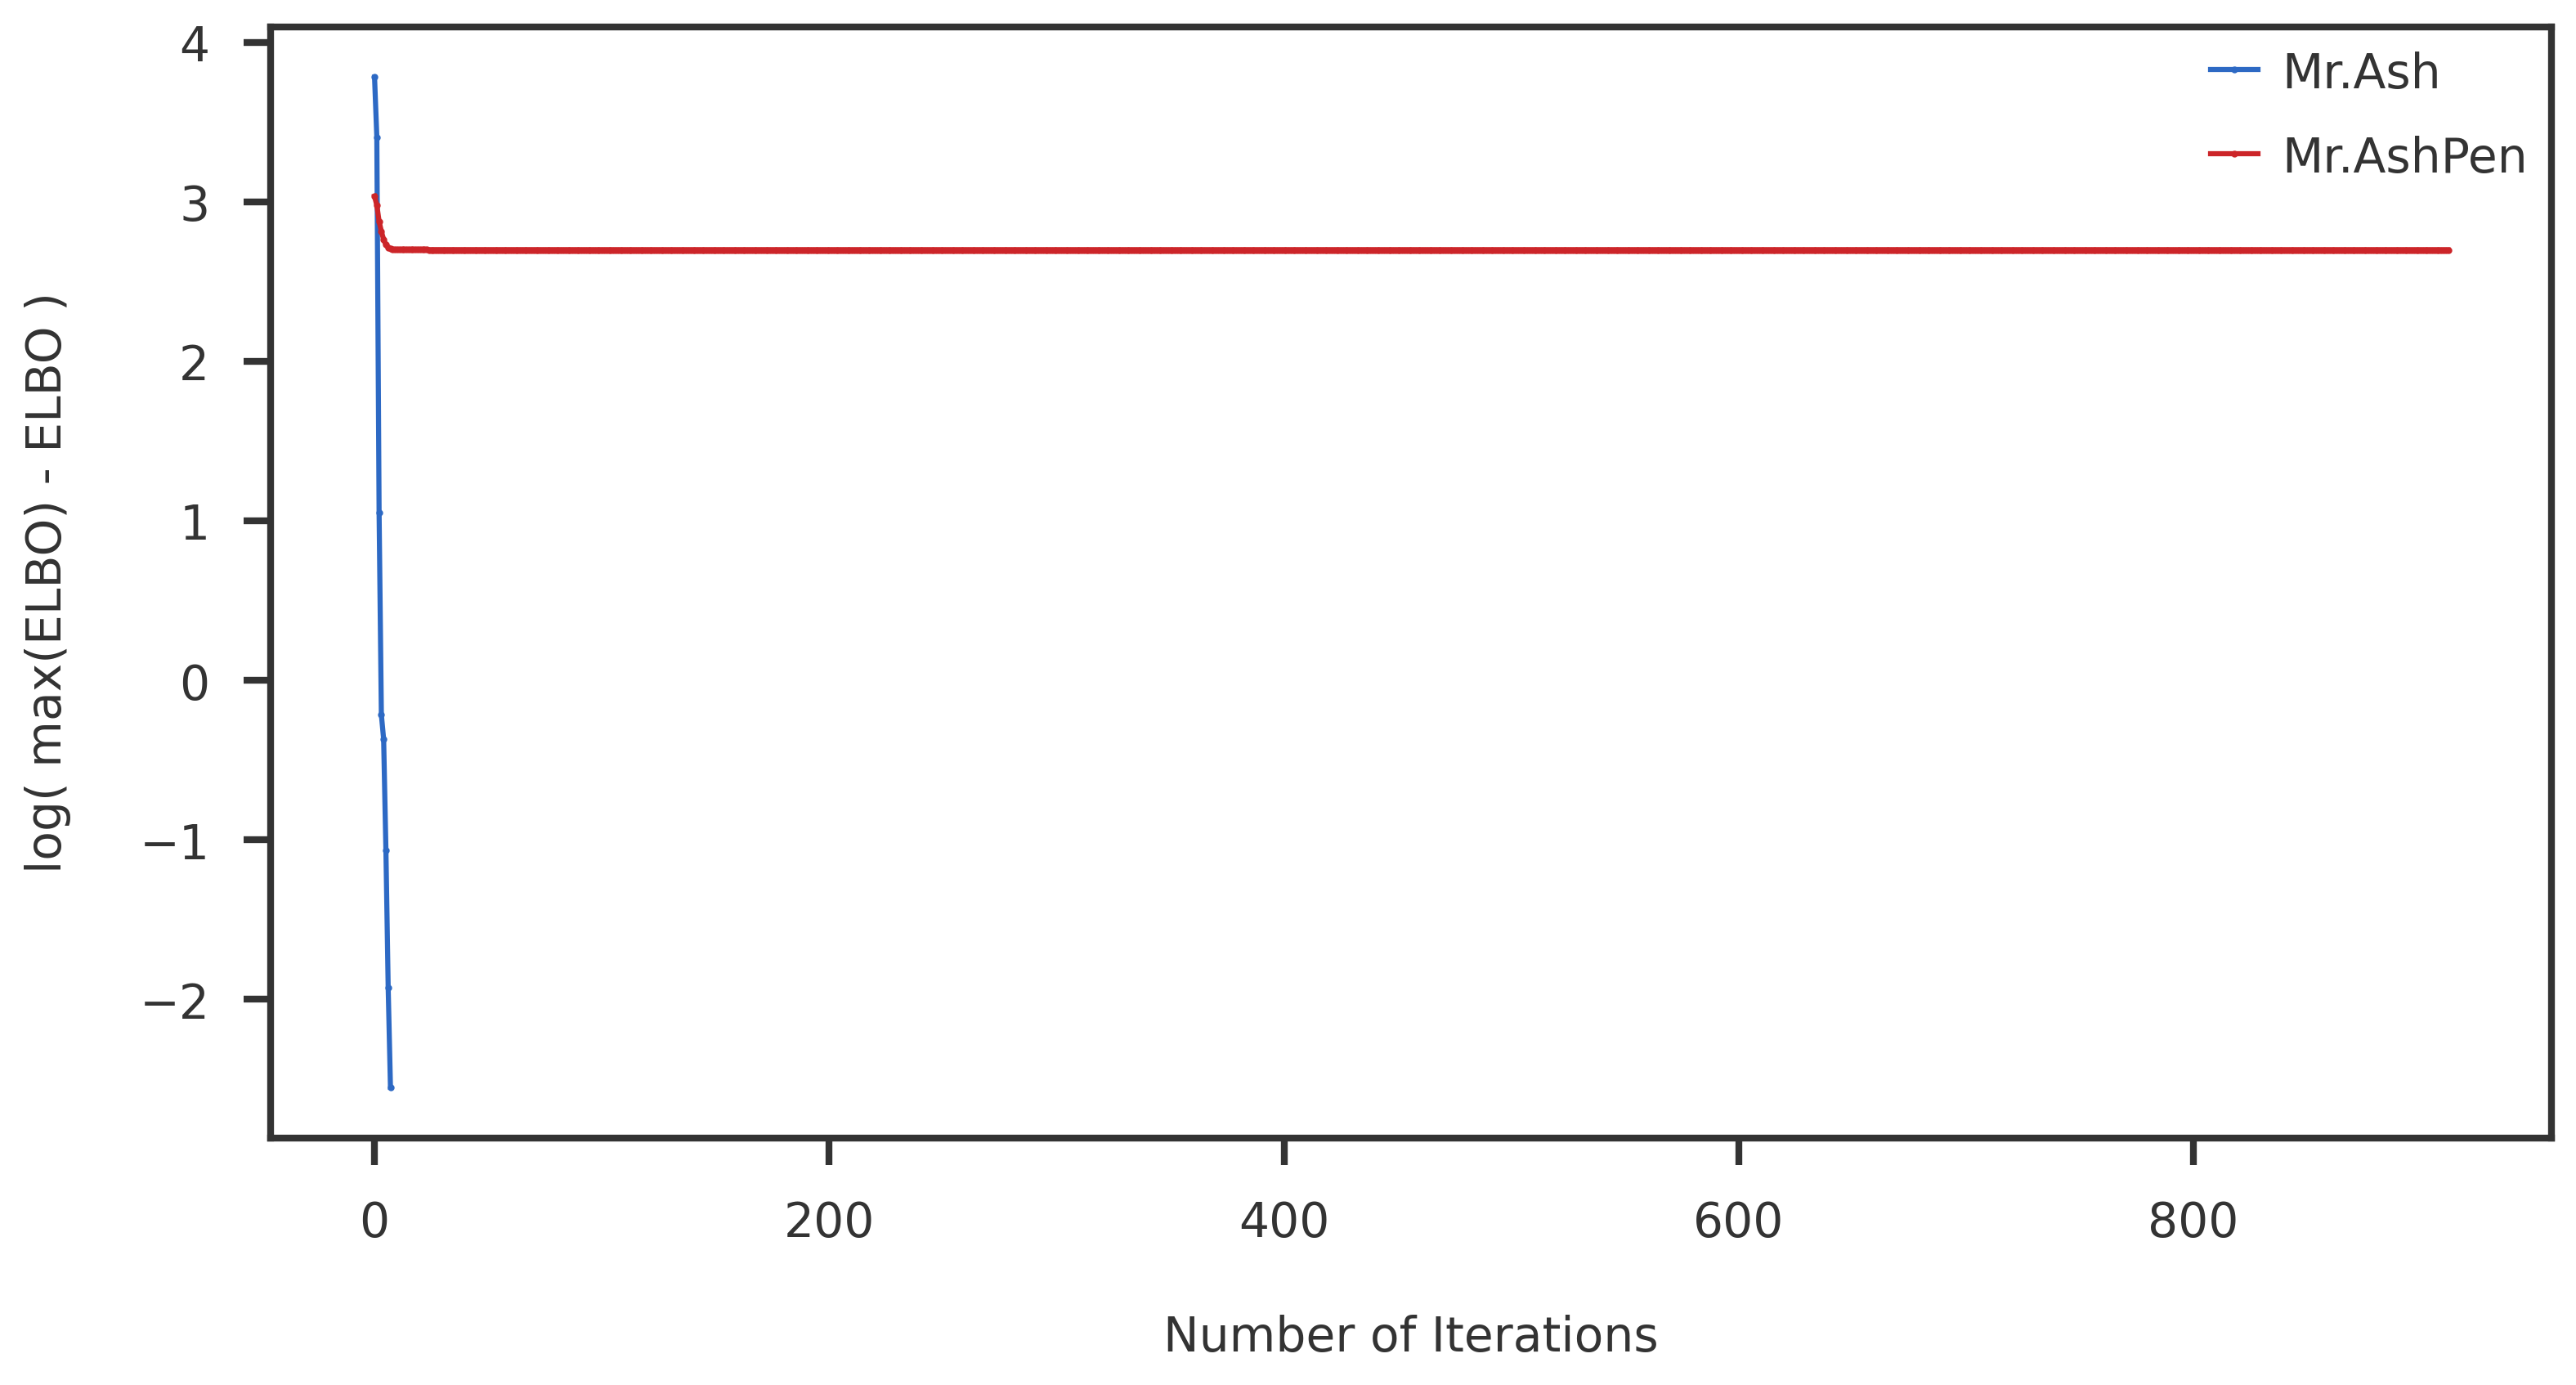

In [189]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(x, y, s = 5, edgecolor = 'black', facecolor='white')
ax1.plot(x, np.dot(H, btrue), label = "True")
ax1.plot(x, tf_y, label = "Trendfiltering")
ax1.plot(x, np.dot(H, plr_lbfgs.coef), label = "Mr.AshPen")
ax1.plot(x, np.dot(H, mrash_r.coef), label = "Mr.Ash")
ax1.legend()

ax1.set_xlabel(r"$x_i$")
ax1.set_ylabel(r"$y = f(x_i)$")
ax2.scatter(btrue, tf_bhat, label = "Trendfiltering")
ax2.scatter(btrue, plr_lbfgs.coef, label = "Mr.AshPen")
ax2.scatter(btrue, mrash_r.coef, label = "Mr.Ash")
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("True b")
ax2.set_ylabel(r"Estimated $\hat{b}$")
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
objs = [mrash_r.obj_path, plr_lbfgs.elbo_path]
methods = ["Mr.Ash", "Mr.AshPen"]
nwarm = [0, 0]
objmin  = np.min([np.min(x) for x in objs])
for obj, method, iteq in zip(objs, methods, nwarm):
    m_obj = np.array(obj)[iteq:] - objmin
    m_obj = m_obj[m_obj > 0]
    ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
             marker = 'o', markersize = 1)
ax1.legend()
ax1.set_xlabel("Number of Iterations")
ax1.set_ylabel("log( max(ELBO) - ELBO )")
plt.show()

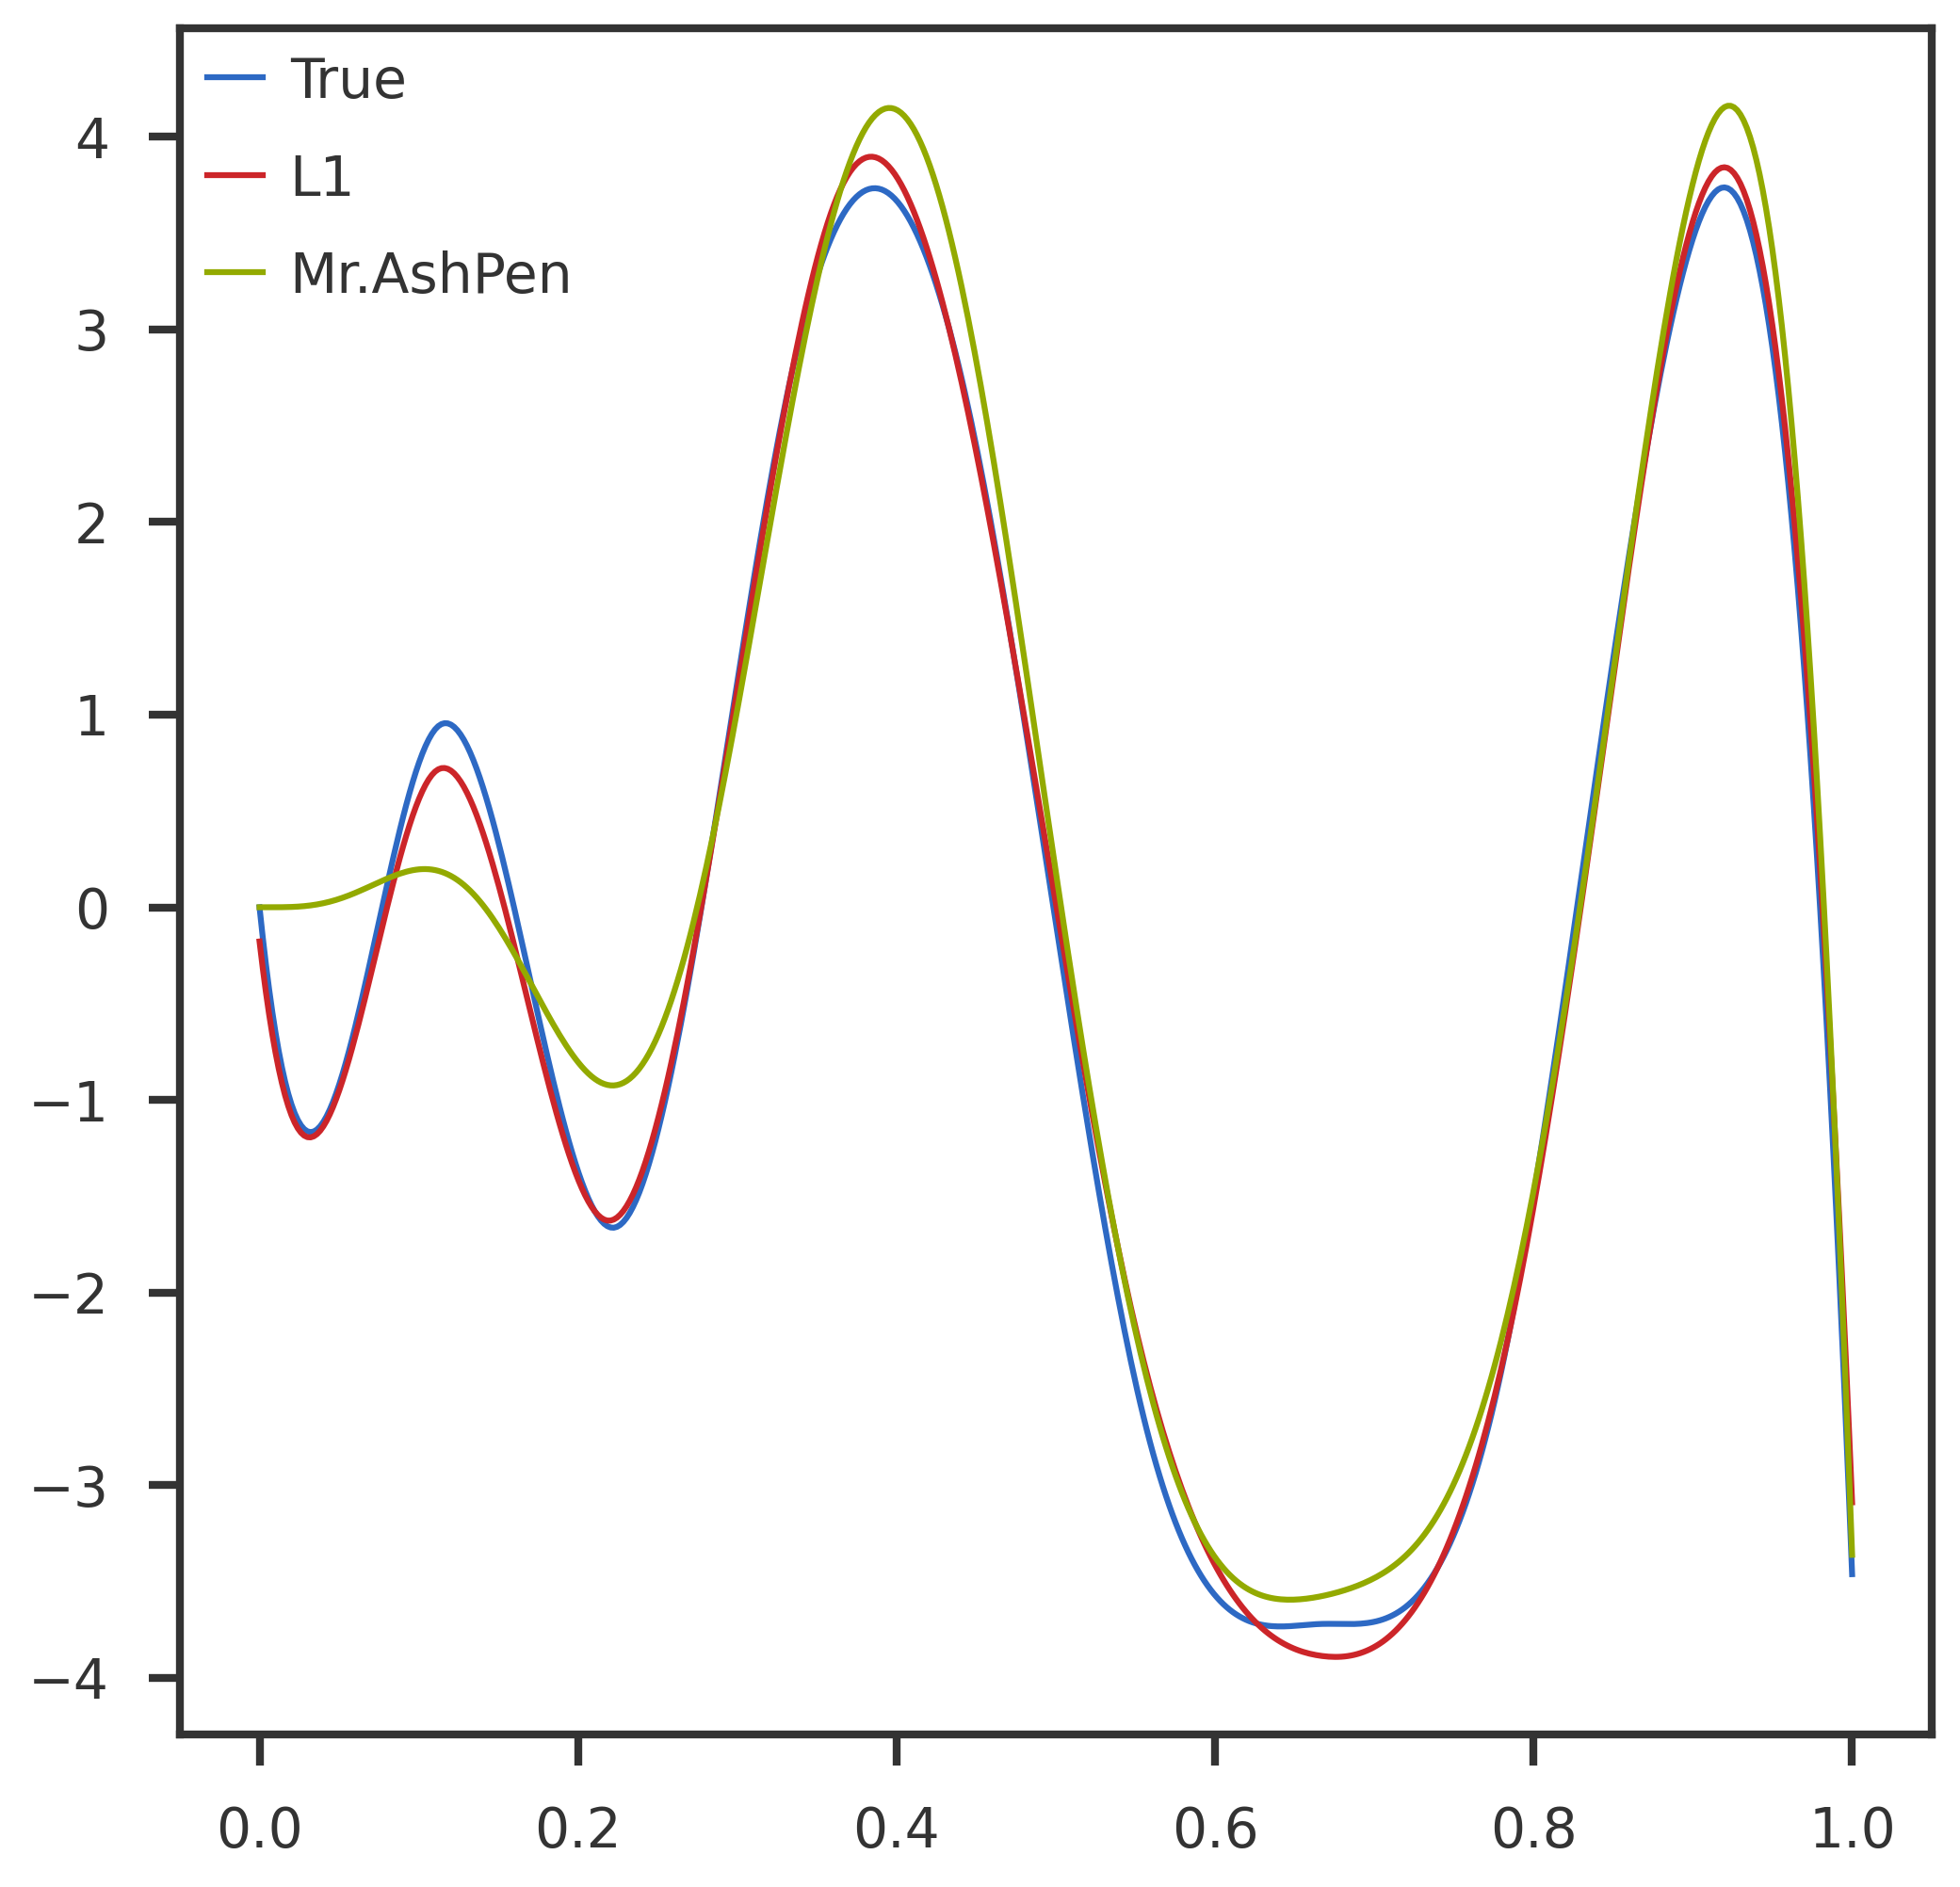

In [187]:
def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

tfact = np.power(n, degree) / np.math.factorial(degree)
Hscale = H / tfact
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x, np.dot(H, btrue), label = "True")
ax1.plot(x, np.dot(Hscale, tf_bhat) * tfact, label = "L1")
#ax1.plot(x, np.dot(H, mrash_r.coef), label = "Mr.Ash")
ax1.plot(x, np.dot(H, plr_lbfgs.coef), label = "Mr.AshPen")
ax1.legend()
plt.show()

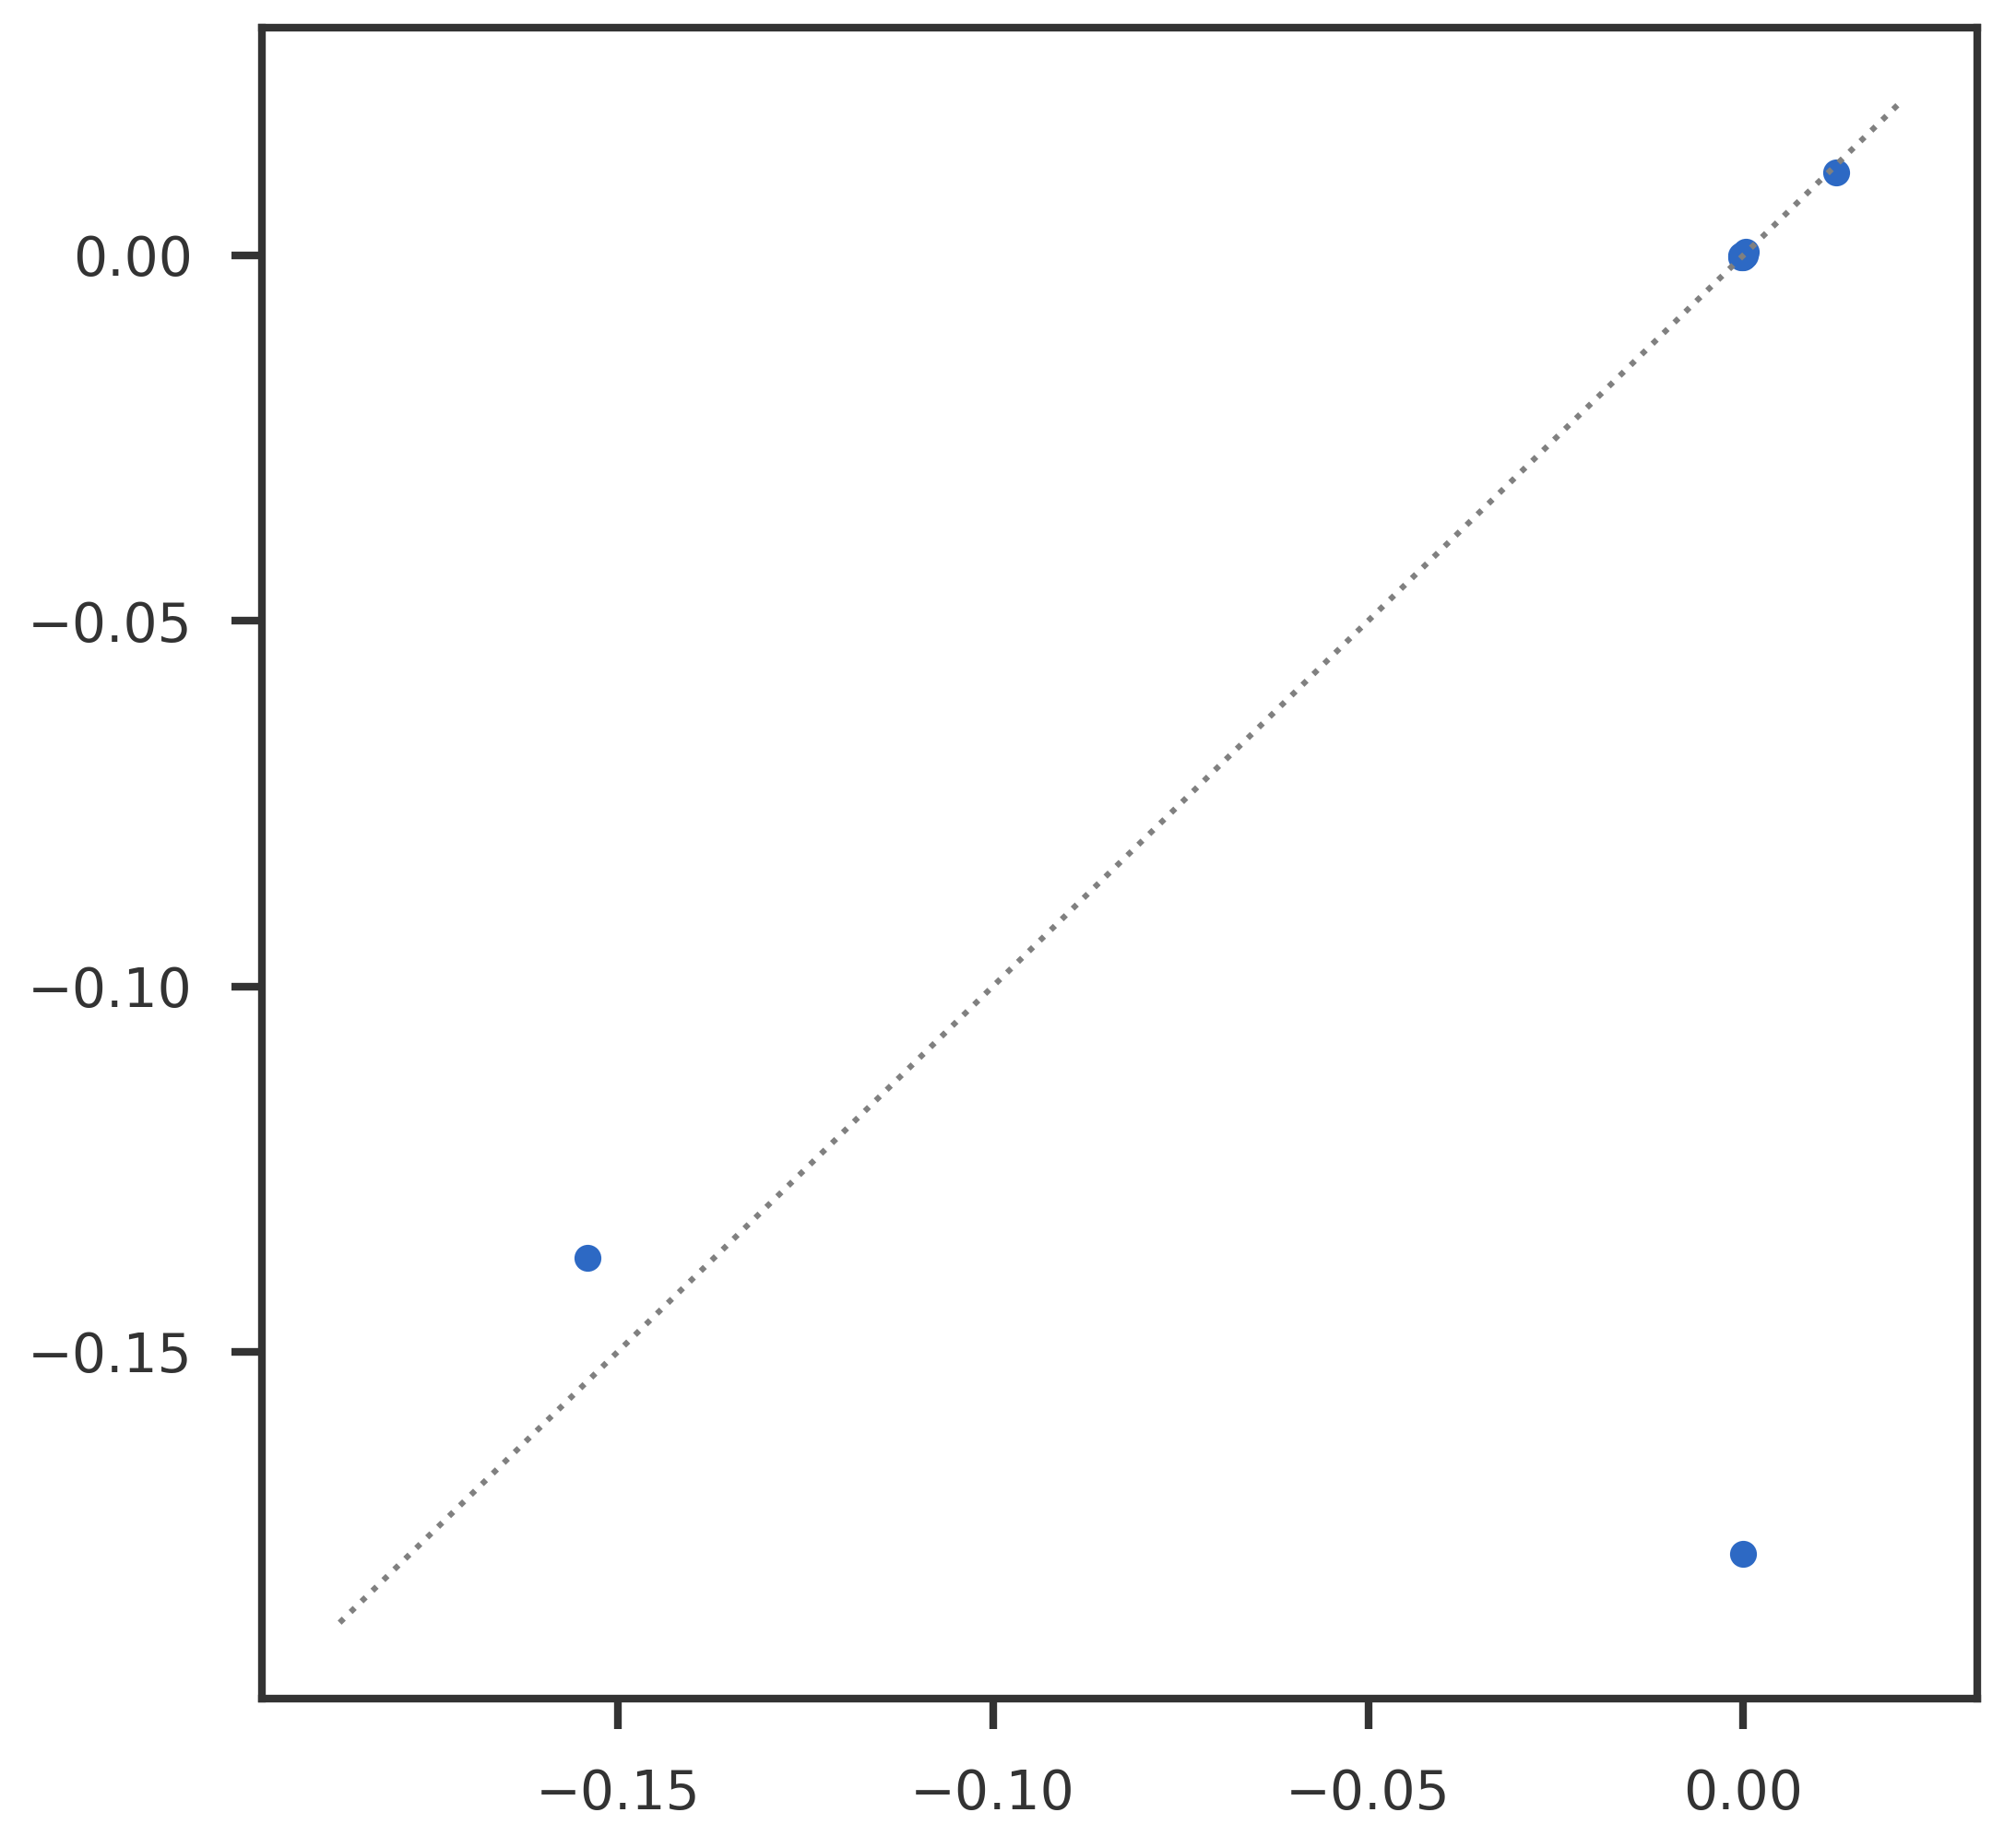

In [181]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(btrue, plr_init.coef / tfact)
mpl_utils.plot_diag(ax1)
plt.show()

In [143]:
np.power(n, degree) / np.math.factorial(degree)

20833333.333333332

In [59]:
mrash_r.residual_var

0.2749480314546818

In [60]:
plr_lbfgs.residual_var

0.28347910125949627

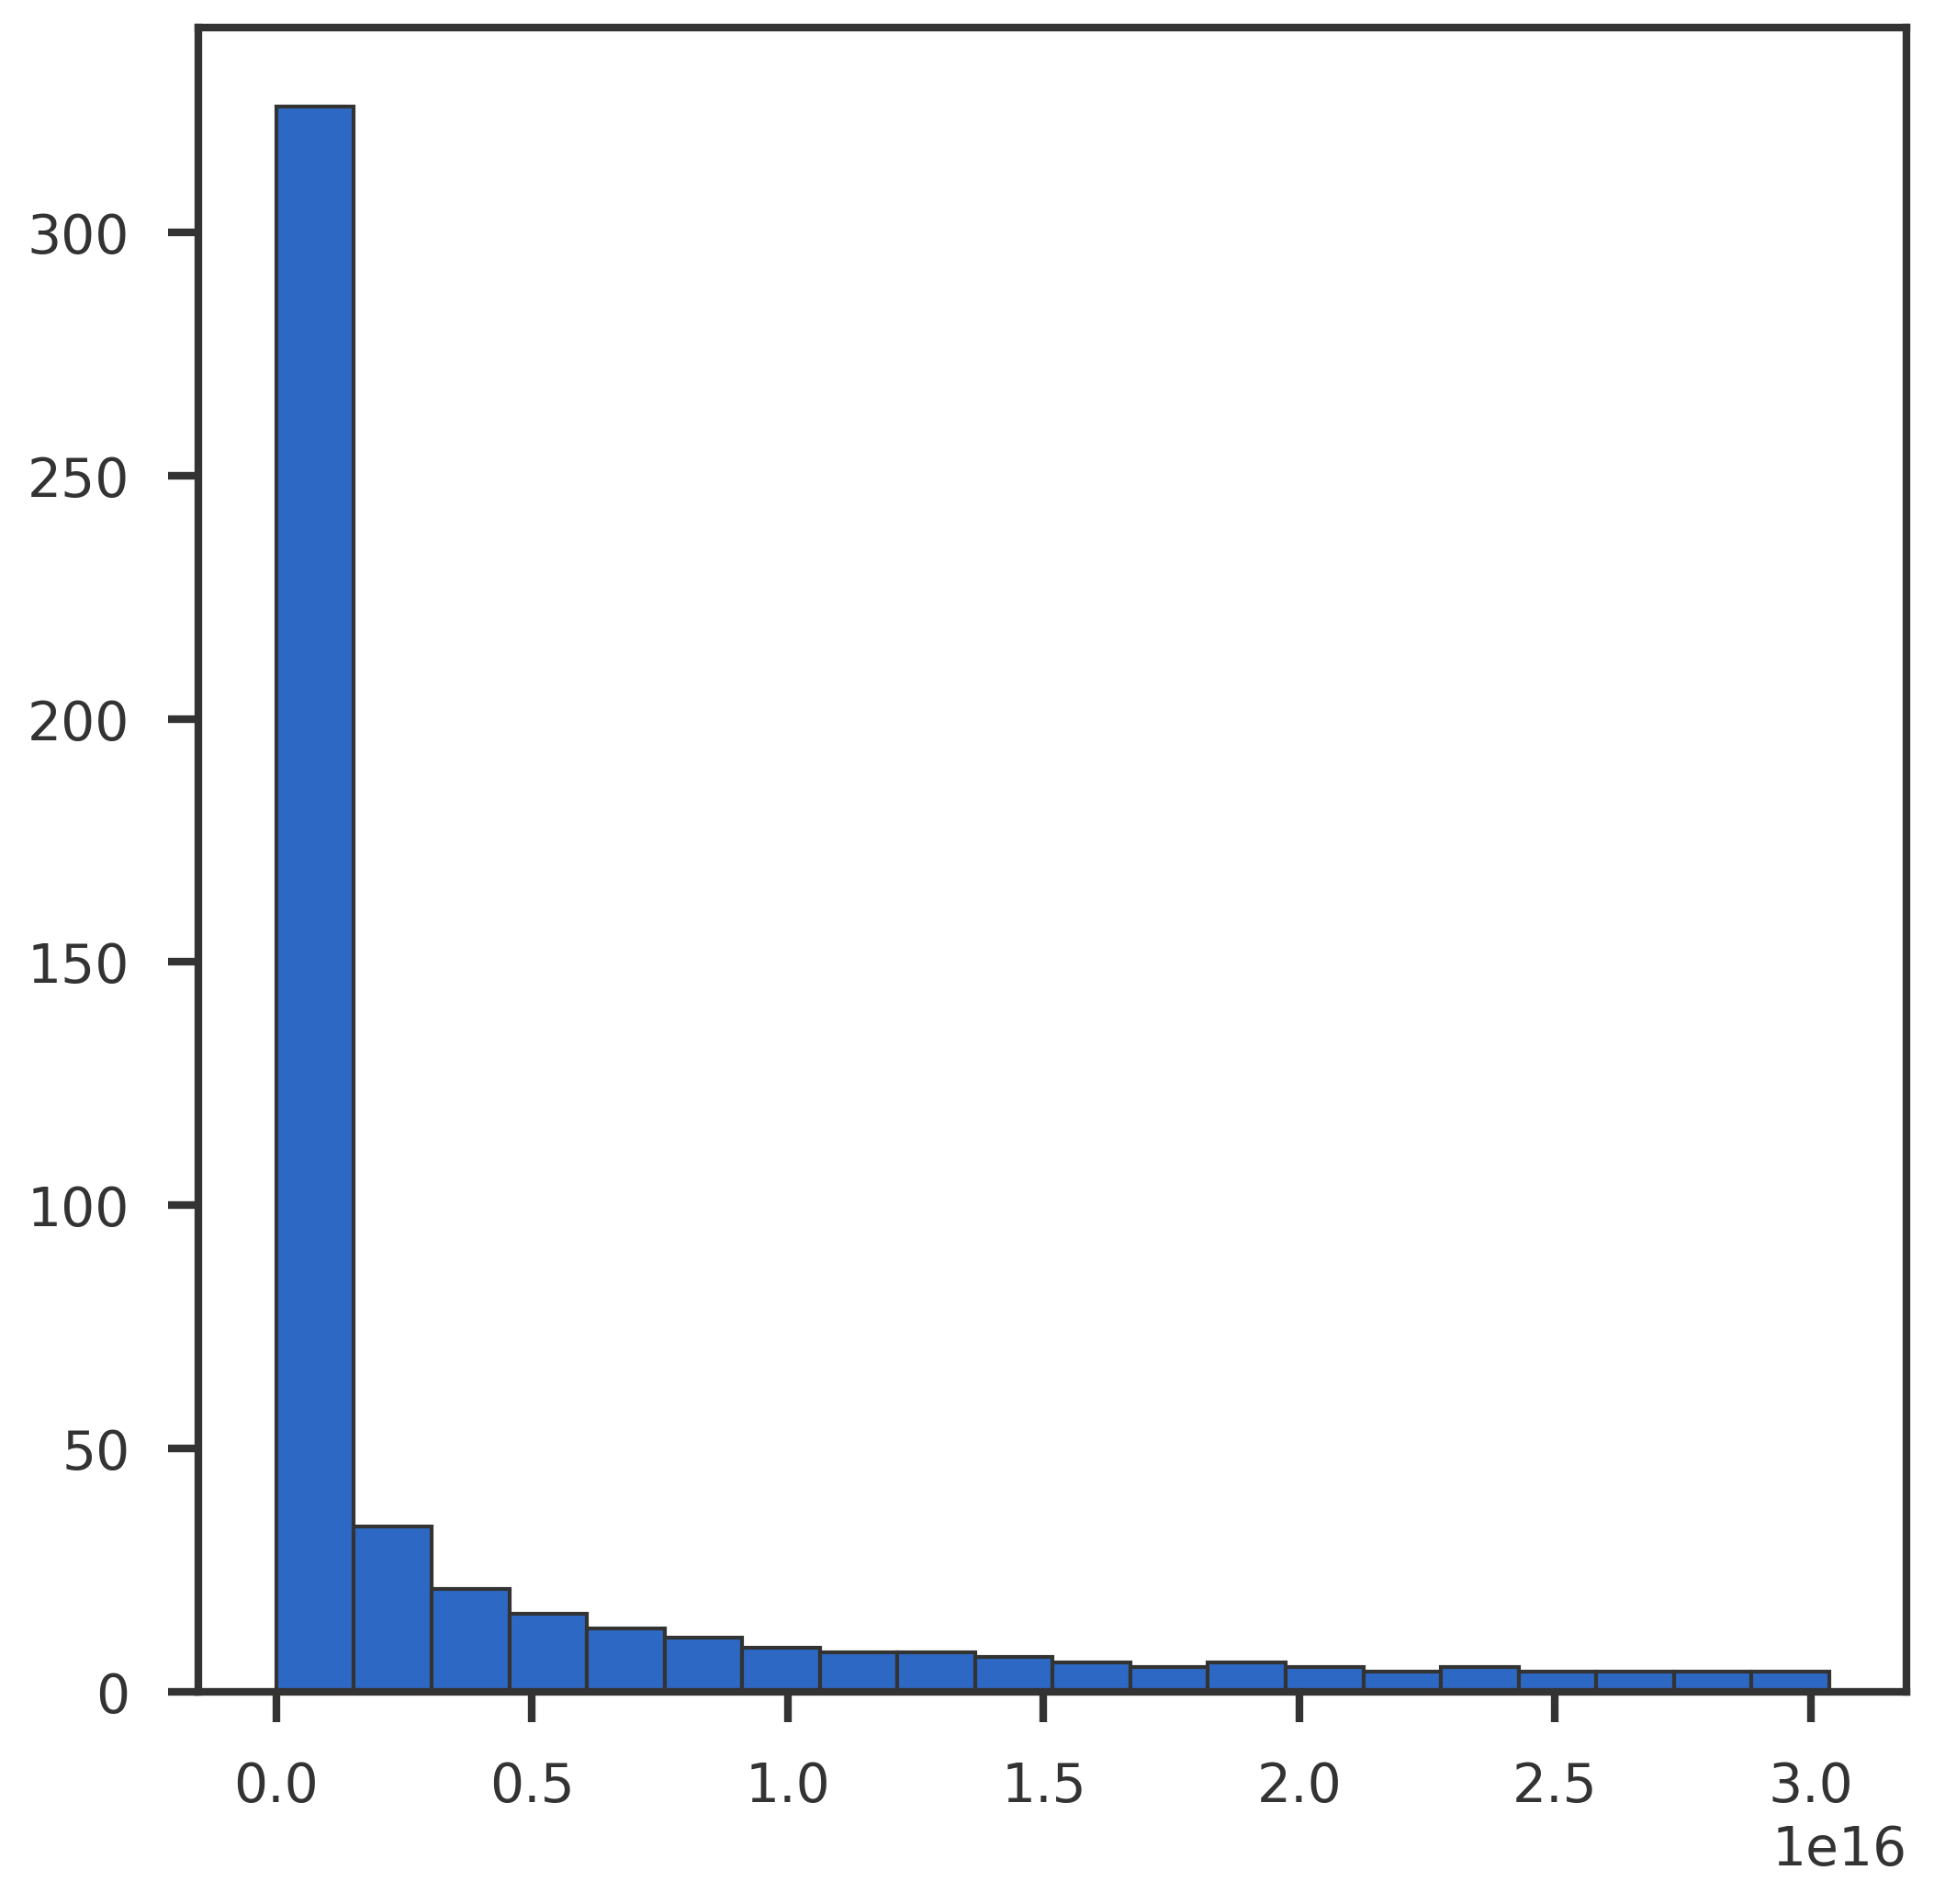

In [138]:
fig = plt.figure()
plt.hist(np.sum(np.square(H), axis = 0))
plt.show()

In [ ]:
'''
Initialization of theta and w for mr.ash.pen
'''
plr_init = PLR(method = 'L-BFGS-B', is_prior_scaled = True, optimize_s = False,
               function_call = 'python',
               debug = False, display_progress = False, calculate_elbo = False, 
               maxiter = 2000, tol = 1e-8)
plr_init.fit(np.eye(p), genlasso_b, sk, binit = genlasso_b, winit = wk, s2init = s2init)
theta_init = plr_init.theta
winit = plr_init.prior
# winit = mix_gauss.emfit(genlasso_b, sk)

'''
Use the initial theta for mr.ash.pen
'''
plr_lbfgs = PLR(method = 'L-BFGS-B', is_prior_scaled = True, function_call = 'python',
                debug = False, display_progress = False, calculate_elbo = True, 
                maxiter = 2000, tol = 1e-8)
plr_lbfgs.fit(X, y, sk, binit = theta_init, winit = winit, s2init = s2init, is_binit_coef = False)


'''
Use the initial coefficients for mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, binit = genlasso_b, winit = winit, s2init = s2init, is_binit_coef = False,
               maxiter = 200, qb_maxiter = 50, calculate_elbo = True)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = genlasso_b, winit = winit, s2init = s2init)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)